**TRAINING - DETECTION**: This script has the code for training the CNNs for the detection task.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/Shareddrives/Projeto DACO/scripts code

/content/drive/Shareddrives/Projeto DACO/scripts code


In [ ]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.6 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
# from torchvision.models import vgg
from torch import optim
from torchvision.ops.focal_loss import sigmoid_focal_loss
import albumentations as A
from albumentations.pytorch import ToTensorV2
from time import time
from tqdm import tqdm
from torchinfo import summary
import datetime
import importlib
import os
import argparse
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torchvision.models as models

import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.utils import class_weight

# Dataloader
import import_ipynb
from dataloader import small_dataset
from sklearn import preprocessing

# from models import VGG16

from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

importing Jupyter notebook from dataloader.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Detection's Label Map
Class 0 -  ['hemorrhage']
Class 1 -  ['no hemorrhage']

Classification's Label Map
Class 0 -  [' epidural']
Class 1 -  [' intraparenchymal']
Class 2 -  [' intraventricular']
Class 3 -  [' subarachnoid']
Class 4 -  [' subdural']
Class 5 -  ['no hemorrhage']
[10.925       0.99036827  1.52663755  0.90805195  0.46675567]
Using cuda


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
###################### TRAINING MODE #####################

dataset_fold = 'windowing' # ['original', 'windowing']
model_selected = 'VGG' # ['VGG', 'ResNeXt']

print(f'Training Mode using {dataset_fold} images')


################## PARAMETERS ##################


img_size = 224
BATCH_SIZE = 16
LEARNING_RATE = 0.000005
NUM_WORKERS = 2
EPOCHS = 95


Training Mode using windowing images


In [ ]:
def epoch_iterations (dataloader, model, loss_fc, device, name, opt=None, is_training=True):
  if (is_training):
      assert opt is not None, "When training, please provide an optimizer."
      model.train() 
  else:
    model.eval()
  
  model.to(device)
  
  tic = time()
  total_time = 0
  
  true_label = []
  final_pred = []
  avg_loss = 0
  
  
  with torch.set_grad_enabled(is_training):
    for img, label, notlabel in tqdm(dataloader):
        img = img.to(device)
        
        for i in label:
          true_label.append(int(i.numpy()))
        
        label = label.type(torch.LongTensor)
        label = label.to(device)
        label_pred = model(img)
        loss = loss_fc(label_pred, label)

        if (is_training):
          opt.zero_grad()
          loss.backward()
          opt.step()

        avg_loss += float(loss.item()) / len(dataloader)

        y_pred = torch.softmax(label_pred, dim=1).argmax(dim=1)
        
        for j in y_pred.cpu():
          final_pred.append(int(j.detach().numpy()))


  toc = time()
  total_time += toc-tic

  print(f'{name} - Time: {toc-tic:.1f}s - Loss: {avg_loss}')

  return avg_loss, true_label, final_pred

  

In [ ]:
import seaborn as sns

def evaluation_metrics (true_label, final_pred):
  # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(true_label, final_pred, labels = [0,1])
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[0,1], yticklabels=[0,1])
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show(block=False)


In [ ]:
def loss_plot (epochs, train_loss, val_loss):
  fig = plt.figure(figsize=(10,5))
  plt.title('Loss')
  plt.plot(epochs, train_loss, label='train')
  plt.plot(epochs, val_loss, label='val')
  plt.legend(loc='best')

  plt.tight_layout()
  plt.legend(loc='best')
  plt.show()


In [ ]:
def loss_plot2 (epochs, train_loss):
  fig = plt.figure(figsize=(10,5))
  plt.title('Loss')
  plt.plot(epochs, train_loss, label='train')
  plt.legend(loc='best')

  plt.tight_layout()
  plt.legend(loc='best')
  plt.show()

Loading dataset

Detection's Label Map
Class 0 -  ['hemorrhage']
Class 1 -  ['no hemorrhage']

Loaded 


Training
* Epoch 1 / 95


100%|██████████| 372/372 [20:49<00:00,  3.36s/it]


TRAIN - Time: 1249.9s - Loss: 0.6764727210005126


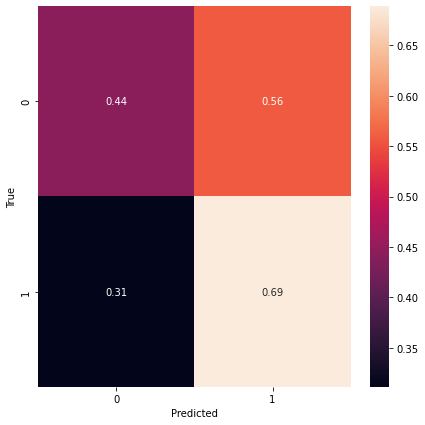

100%|██████████| 80/80 [04:03<00:00,  3.04s/it]


VALIDATION - Time: 243.4s - Loss: 0.7218009199947119


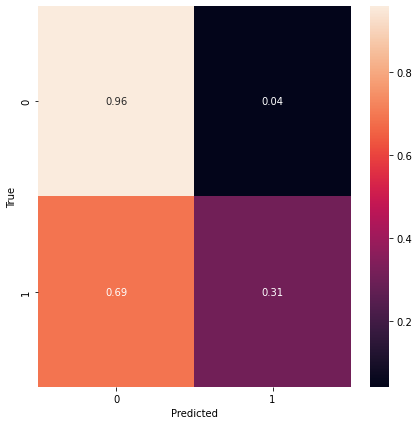

* Epoch 2 / 95


100%|██████████| 372/372 [02:05<00:00,  2.96it/s]


TRAIN - Time: 125.6s - Loss: 0.677474024074693


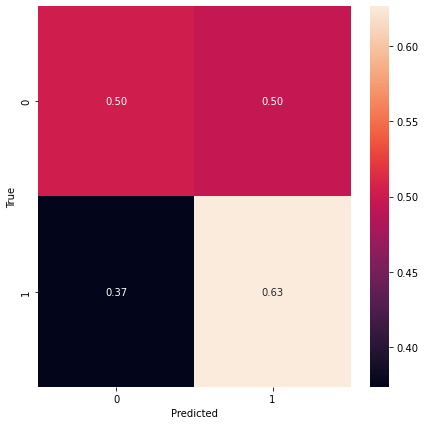

100%|██████████| 80/80 [00:13<00:00,  5.85it/s]


VALIDATION - Time: 13.7s - Loss: 0.5996745236217975


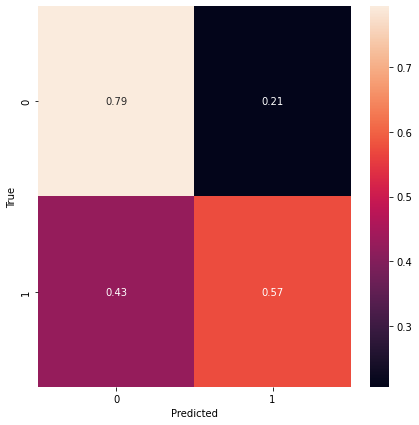

* Epoch 3 / 95


100%|██████████| 372/372 [02:03<00:00,  3.01it/s]


TRAIN - Time: 123.6s - Loss: 0.6577989397350176


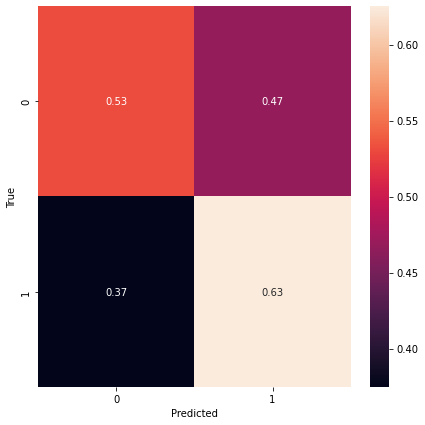

100%|██████████| 80/80 [00:13<00:00,  5.90it/s]


VALIDATION - Time: 13.6s - Loss: 0.5785351622849705


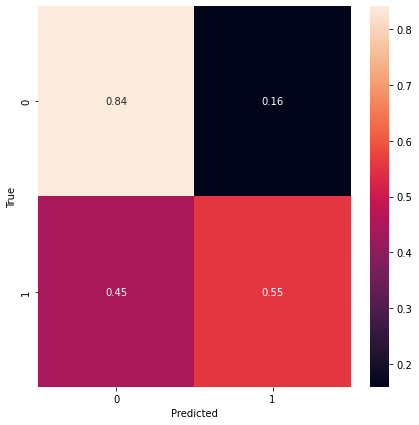

* Epoch 4 / 95


100%|██████████| 372/372 [02:08<00:00,  2.89it/s]


TRAIN - Time: 128.8s - Loss: 0.6528353892987775


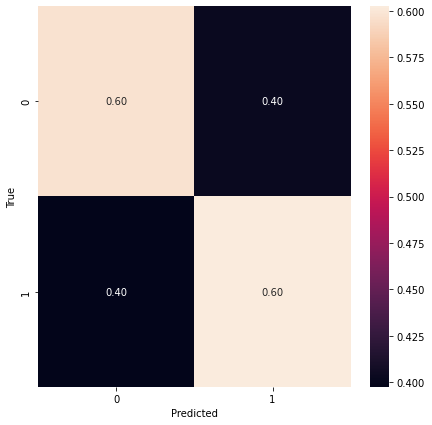

100%|██████████| 80/80 [00:13<00:00,  5.81it/s]


VALIDATION - Time: 13.8s - Loss: 0.6609978817403318


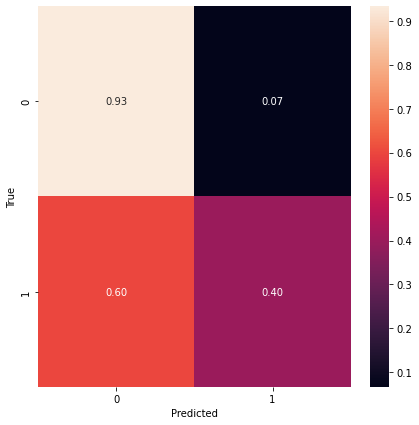

* Epoch 5 / 95


100%|██████████| 372/372 [02:04<00:00,  2.98it/s]


TRAIN - Time: 124.7s - Loss: 0.6100122071402043


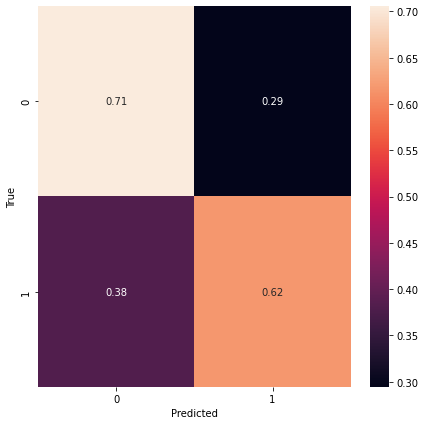

100%|██████████| 80/80 [00:14<00:00,  5.69it/s]


VALIDATION - Time: 14.1s - Loss: 0.6259883936494588


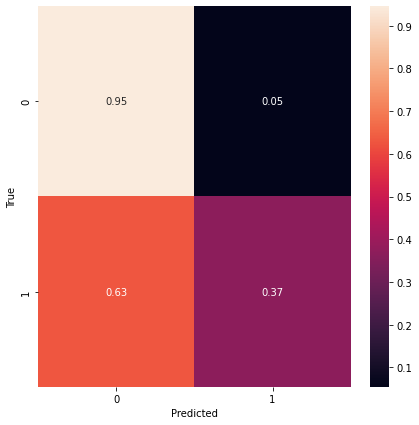

* Epoch 6 / 95


100%|██████████| 372/372 [02:07<00:00,  2.91it/s]


TRAIN - Time: 127.8s - Loss: 0.5950581429786582


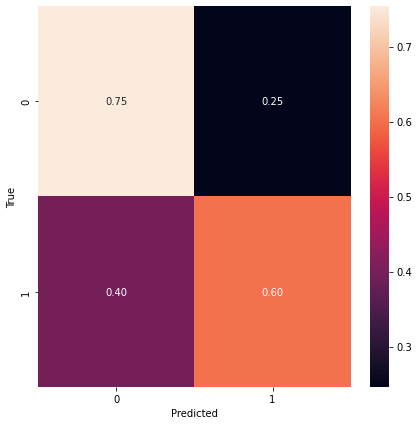

100%|██████████| 80/80 [00:13<00:00,  5.74it/s]


VALIDATION - Time: 14.0s - Loss: 0.5758156888186932


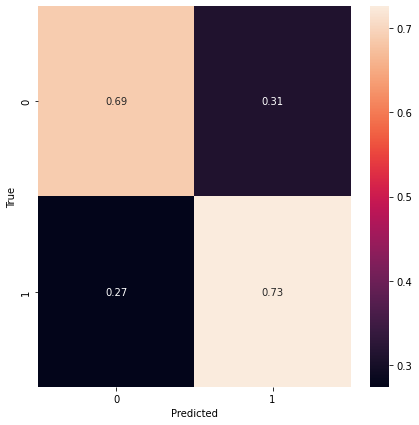

* Epoch 7 / 95


100%|██████████| 372/372 [02:05<00:00,  2.97it/s]


TRAIN - Time: 125.5s - Loss: 0.5935288549110451


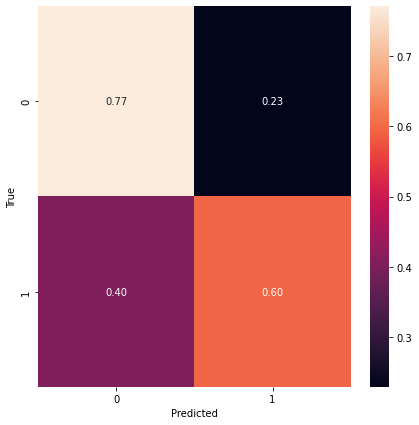

100%|██████████| 80/80 [00:14<00:00,  5.62it/s]


VALIDATION - Time: 14.2s - Loss: 0.5546268183737993


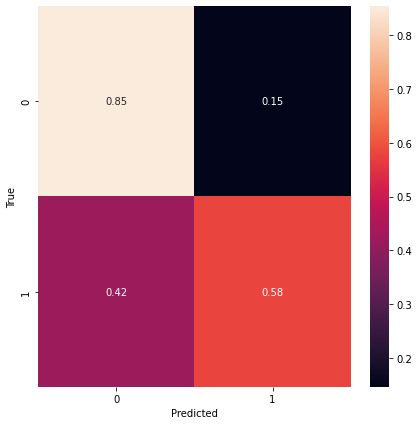

* Epoch 8 / 95


100%|██████████| 372/372 [02:08<00:00,  2.89it/s]


TRAIN - Time: 128.7s - Loss: 0.5915828891178614


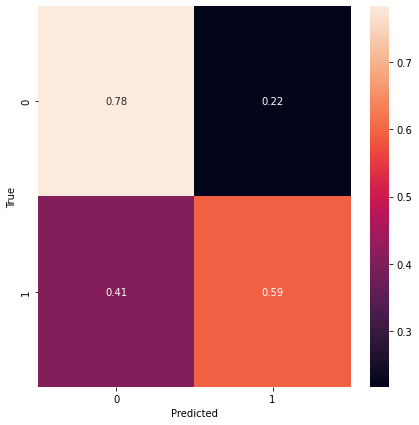

100%|██████████| 80/80 [00:14<00:00,  5.71it/s]


VALIDATION - Time: 14.0s - Loss: 0.550477446988225


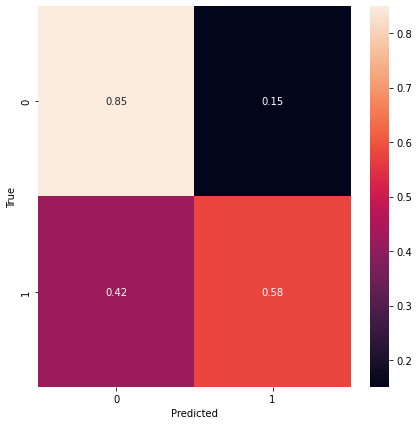

* Epoch 9 / 95


100%|██████████| 372/372 [02:04<00:00,  2.98it/s]


TRAIN - Time: 124.8s - Loss: 0.5841028249712406


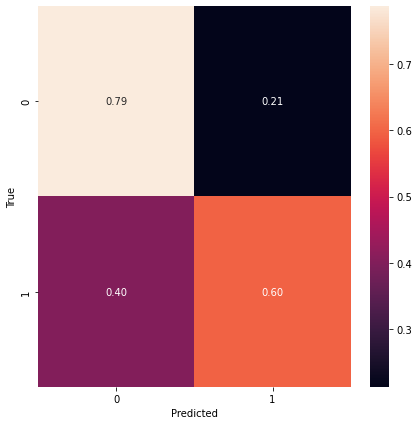

100%|██████████| 80/80 [00:14<00:00,  5.68it/s]


VALIDATION - Time: 14.1s - Loss: 0.5380900349467994


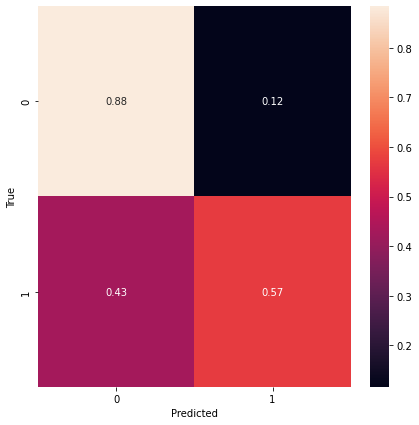

* Epoch 10 / 95


100%|██████████| 372/372 [02:04<00:00,  2.98it/s]


TRAIN - Time: 124.9s - Loss: 0.5713692192909536


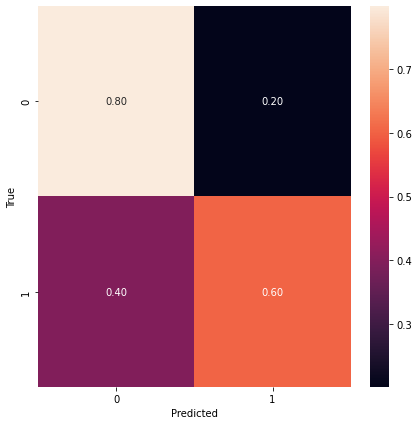

100%|██████████| 80/80 [00:12<00:00,  6.22it/s]


VALIDATION - Time: 12.9s - Loss: 0.5198605276644229


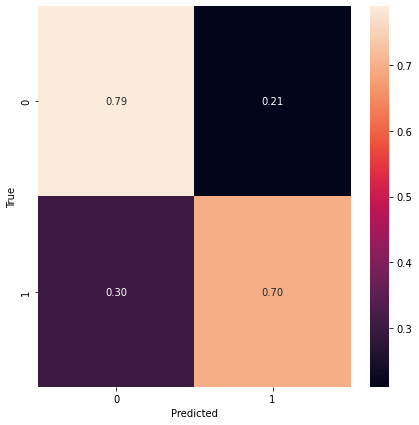

* Epoch 11 / 95


100%|██████████| 372/372 [02:04<00:00,  2.98it/s]


TRAIN - Time: 124.7s - Loss: 0.5574435666604066


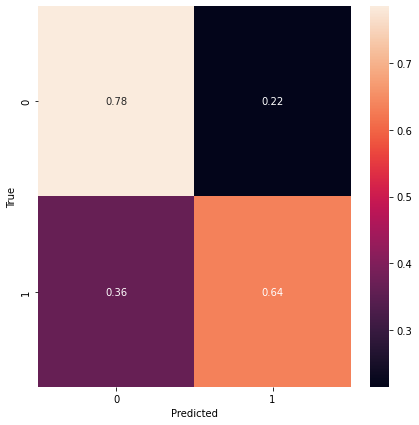

100%|██████████| 80/80 [00:12<00:00,  6.18it/s]


VALIDATION - Time: 13.0s - Loss: 0.5056743834167717


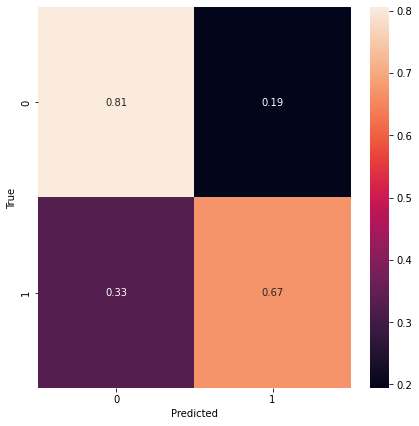

* Epoch 12 / 95


100%|██████████| 372/372 [02:07<00:00,  2.93it/s]


TRAIN - Time: 127.1s - Loss: 0.5531936537033767


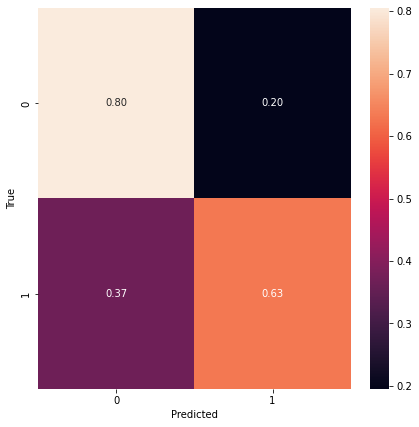

100%|██████████| 80/80 [00:13<00:00,  5.99it/s]


VALIDATION - Time: 13.4s - Loss: 0.5450675806030632


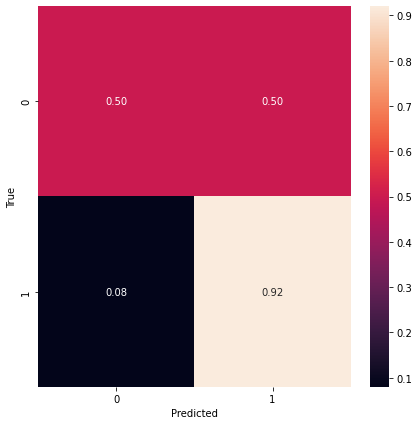

* Epoch 13 / 95


100%|██████████| 372/372 [02:04<00:00,  2.98it/s]


TRAIN - Time: 124.8s - Loss: 0.5498066049029109


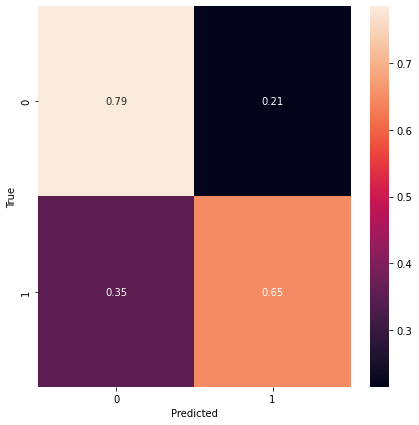

100%|██████████| 80/80 [00:13<00:00,  5.98it/s]


VALIDATION - Time: 13.4s - Loss: 0.4887926198542117


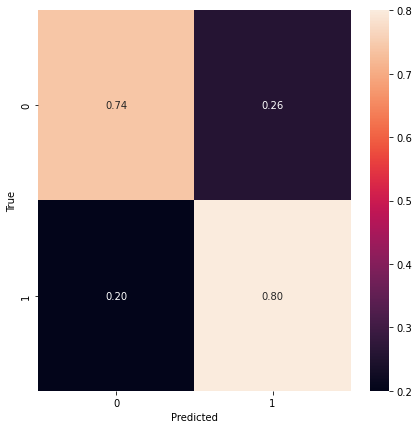

* Epoch 14 / 95


100%|██████████| 372/372 [02:07<00:00,  2.91it/s]


TRAIN - Time: 127.8s - Loss: 0.5462684012869358


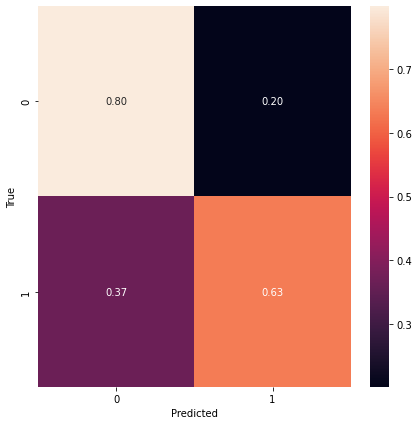

100%|██████████| 80/80 [00:13<00:00,  5.91it/s]


VALIDATION - Time: 13.6s - Loss: 0.4878933615982533


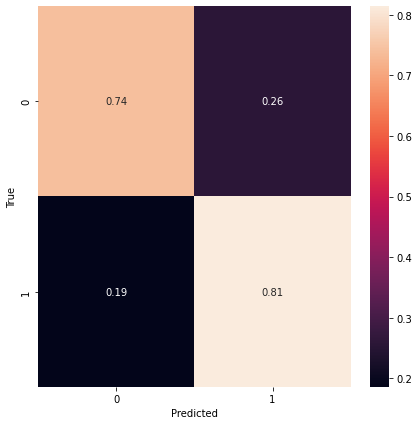

* Epoch 15 / 95


100%|██████████| 372/372 [02:06<00:00,  2.95it/s]


TRAIN - Time: 126.1s - Loss: 0.5384635205871316


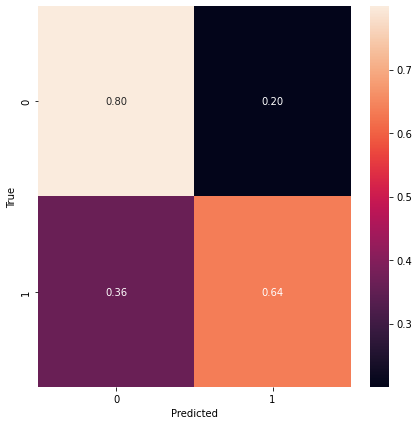

100%|██████████| 80/80 [00:13<00:00,  5.82it/s]


VALIDATION - Time: 13.7s - Loss: 0.47206191457808017


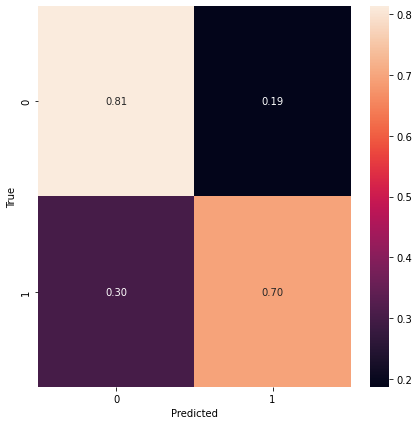

* Epoch 16 / 95


100%|██████████| 372/372 [02:08<00:00,  2.90it/s]


TRAIN - Time: 128.2s - Loss: 0.5355792784642791


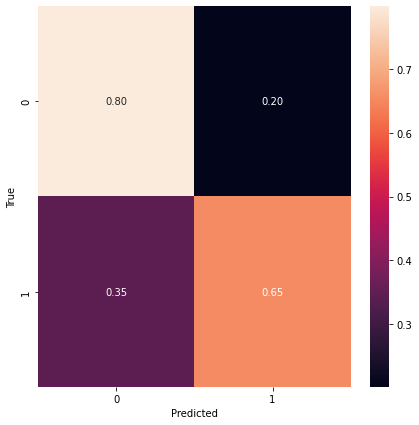

100%|██████████| 80/80 [00:13<00:00,  5.78it/s]


VALIDATION - Time: 13.8s - Loss: 0.47748349290341147


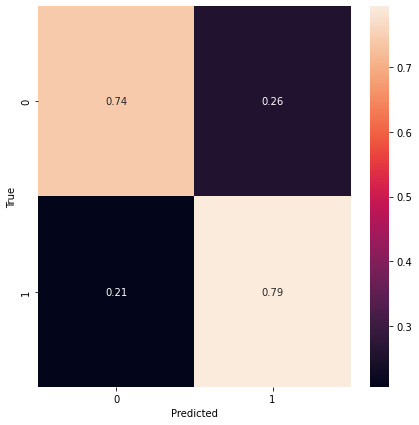

* Epoch 17 / 95


100%|██████████| 372/372 [02:05<00:00,  2.97it/s]


TRAIN - Time: 125.4s - Loss: 0.5344472441782234


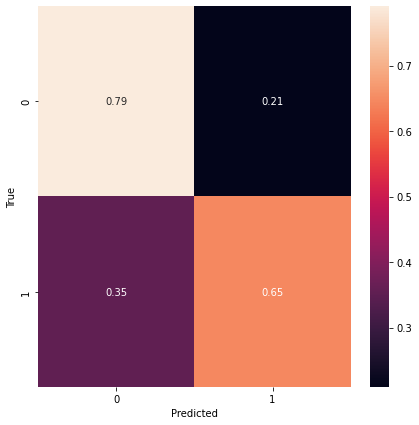

100%|██████████| 80/80 [00:14<00:00,  5.63it/s]


VALIDATION - Time: 14.2s - Loss: 0.4700000625103714


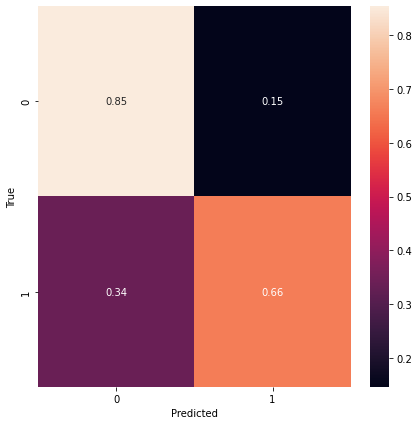

* Epoch 18 / 95


100%|██████████| 372/372 [02:07<00:00,  2.91it/s]


TRAIN - Time: 128.0s - Loss: 0.5373726700262359


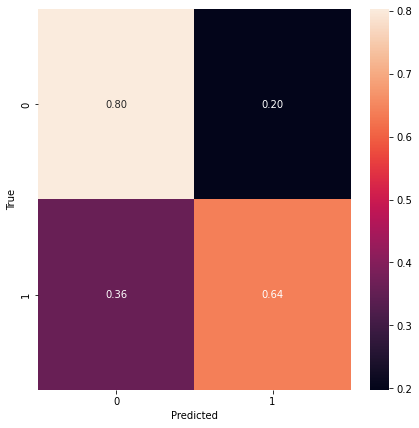

100%|██████████| 80/80 [00:14<00:00,  5.64it/s]


VALIDATION - Time: 14.2s - Loss: 0.4746072664856912


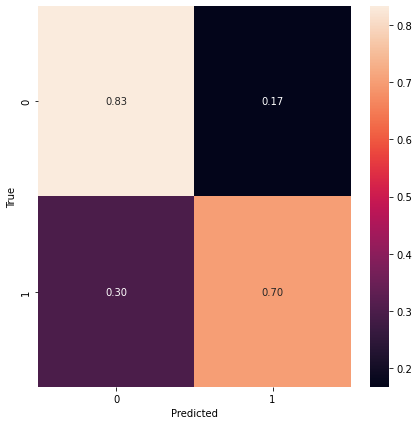

* Epoch 19 / 95


100%|██████████| 372/372 [02:05<00:00,  2.96it/s]


TRAIN - Time: 125.7s - Loss: 0.5323491643273063


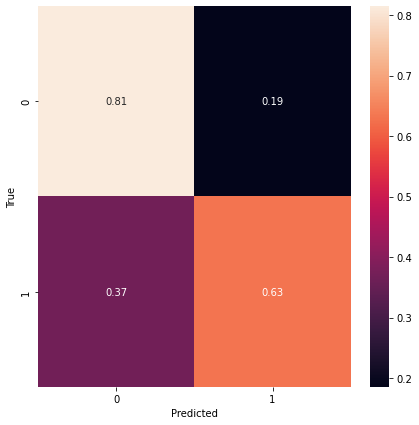

100%|██████████| 80/80 [00:14<00:00,  5.57it/s]


VALIDATION - Time: 14.4s - Loss: 0.4697559326887132


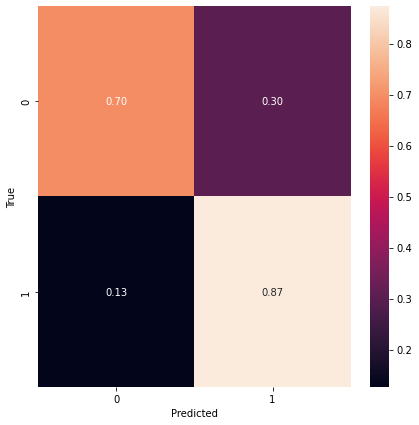

* Epoch 20 / 95


100%|██████████| 372/372 [02:06<00:00,  2.94it/s]


TRAIN - Time: 126.7s - Loss: 0.5164929506999834


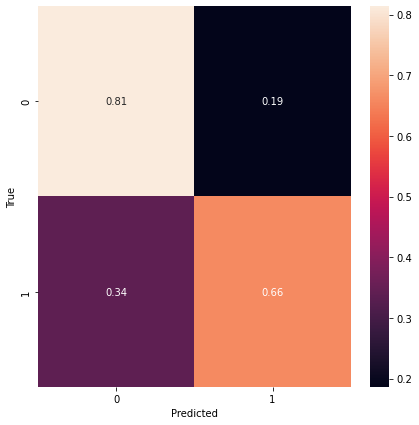

100%|██████████| 80/80 [00:13<00:00,  6.00it/s]


VALIDATION - Time: 13.3s - Loss: 0.4699170656502247


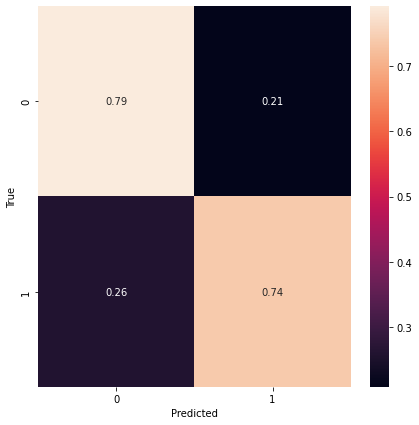

* Epoch 21 / 95


100%|██████████| 372/372 [02:04<00:00,  2.98it/s]


TRAIN - Time: 124.9s - Loss: 0.5238588301324716


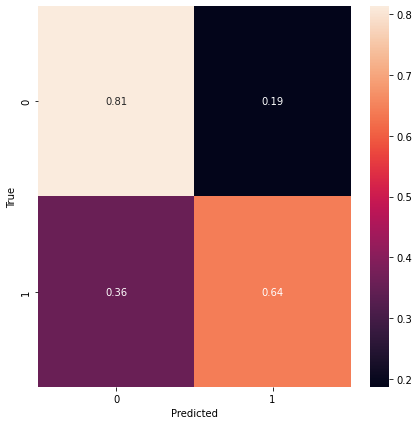

100%|██████████| 80/80 [00:13<00:00,  5.92it/s]


VALIDATION - Time: 13.5s - Loss: 0.5268495533615349


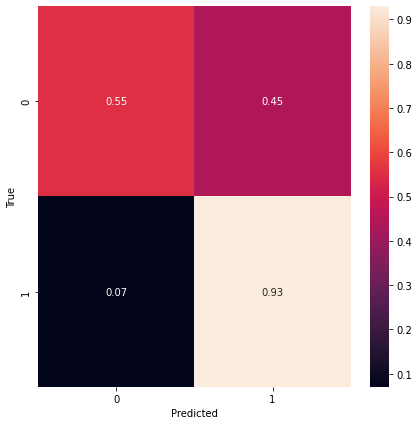

* Epoch 22 / 95


100%|██████████| 372/372 [02:05<00:00,  2.98it/s]


TRAIN - Time: 125.1s - Loss: 0.5245643180384432


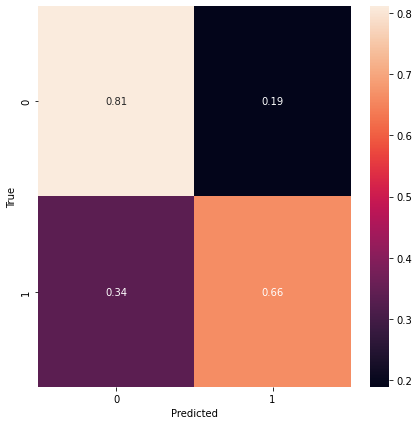

100%|██████████| 80/80 [00:13<00:00,  5.88it/s]


VALIDATION - Time: 13.6s - Loss: 0.4633114835247396


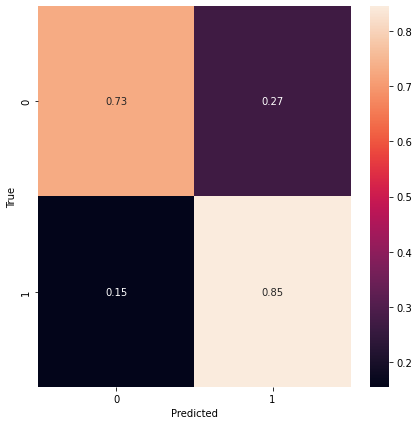

* Epoch 23 / 95


100%|██████████| 372/372 [02:06<00:00,  2.95it/s]


TRAIN - Time: 126.3s - Loss: 0.5248898732405838


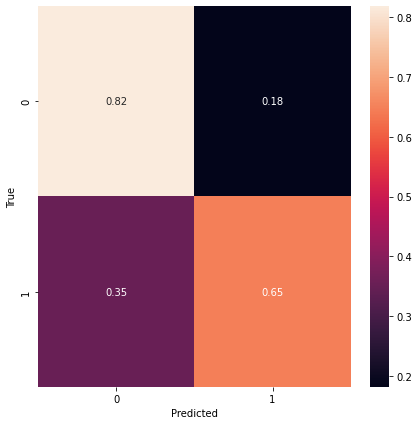

100%|██████████| 80/80 [00:13<00:00,  5.80it/s]


VALIDATION - Time: 13.8s - Loss: 0.4767533361911773


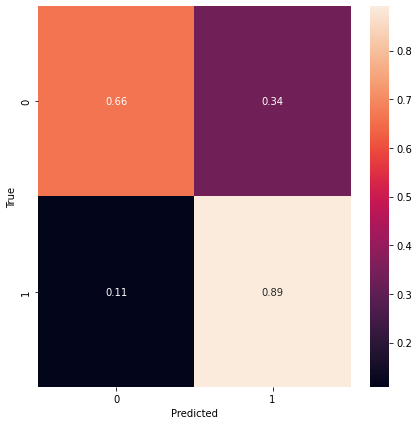

* Epoch 24 / 95


100%|██████████| 372/372 [02:05<00:00,  2.97it/s]


TRAIN - Time: 125.3s - Loss: 0.5128622089102063


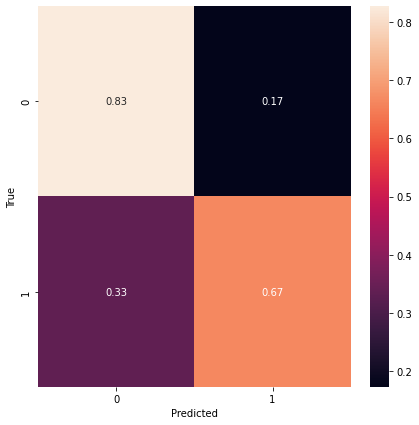

100%|██████████| 80/80 [00:13<00:00,  5.84it/s]


VALIDATION - Time: 13.7s - Loss: 0.4885524401441215


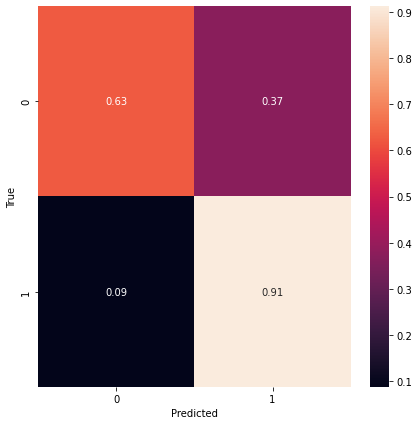

* Epoch 25 / 95


100%|██████████| 372/372 [02:07<00:00,  2.91it/s]


TRAIN - Time: 127.8s - Loss: 0.5130722638499997


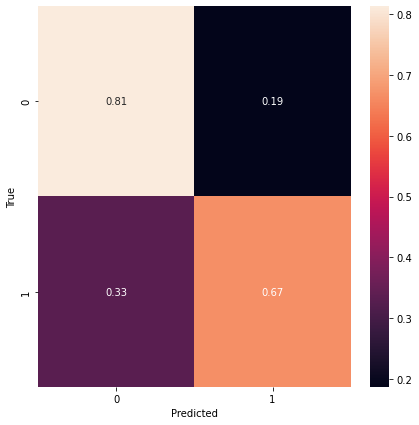

100%|██████████| 80/80 [00:13<00:00,  5.73it/s]


VALIDATION - Time: 14.0s - Loss: 0.46727861277759064


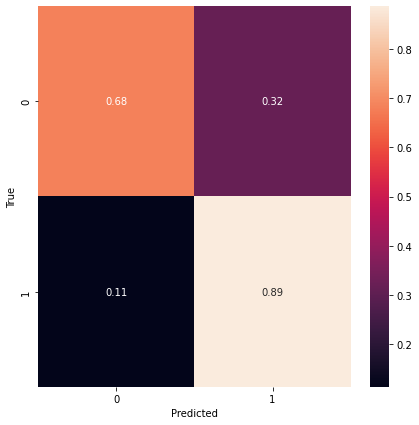

* Epoch 26 / 95


100%|██████████| 372/372 [02:06<00:00,  2.95it/s]


TRAIN - Time: 126.2s - Loss: 0.5220891812475777


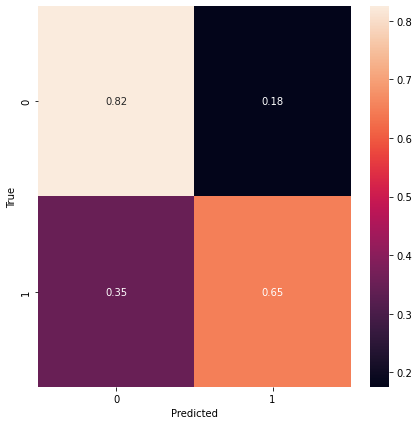

100%|██████████| 80/80 [00:15<00:00,  5.27it/s]


VALIDATION - Time: 15.2s - Loss: 0.4923908669501542


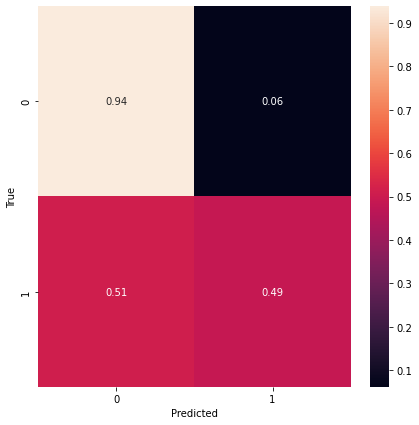

* Epoch 27 / 95


100%|██████████| 372/372 [02:10<00:00,  2.84it/s]


TRAIN - Time: 130.9s - Loss: 0.5175593891130983


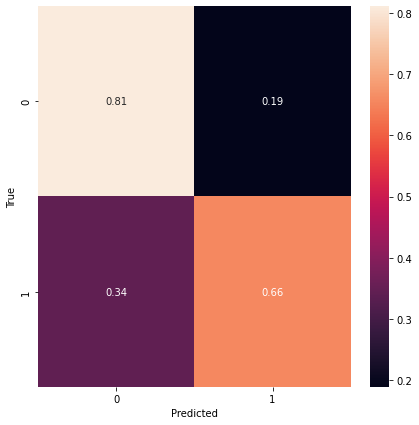

100%|██████████| 80/80 [00:15<00:00,  5.33it/s]


VALIDATION - Time: 15.0s - Loss: 0.47108595110476015


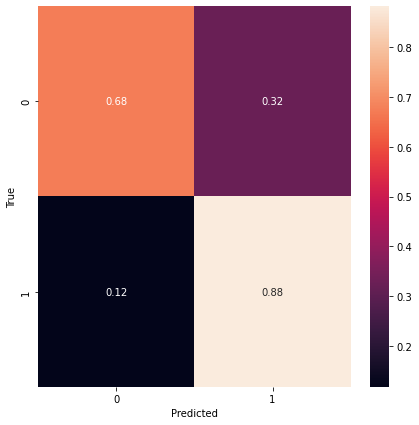

* Epoch 28 / 95


100%|██████████| 372/372 [02:12<00:00,  2.81it/s]


TRAIN - Time: 132.4s - Loss: 0.5075409584228069


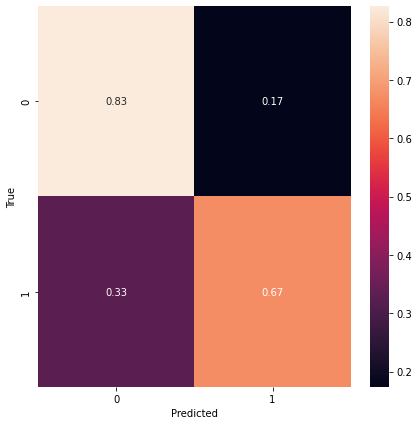

100%|██████████| 80/80 [00:15<00:00,  5.03it/s]


VALIDATION - Time: 15.9s - Loss: 0.44499569162726416


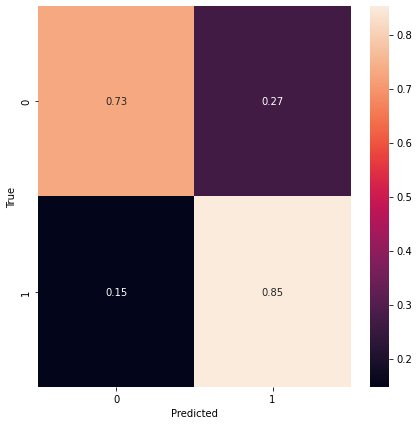

* Epoch 29 / 95


100%|██████████| 372/372 [02:08<00:00,  2.89it/s]


TRAIN - Time: 128.8s - Loss: 0.5065065735290127


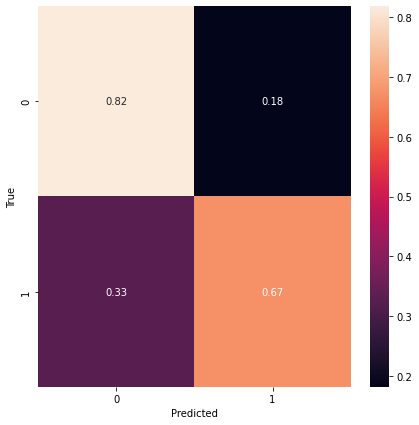

100%|██████████| 80/80 [00:14<00:00,  5.67it/s]


VALIDATION - Time: 14.1s - Loss: 0.44466672576963917


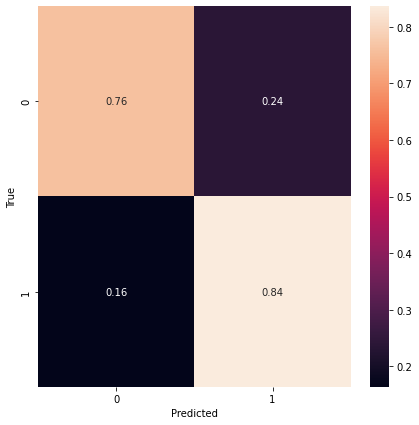

* Epoch 30 / 95


100%|██████████| 372/372 [02:12<00:00,  2.81it/s]


TRAIN - Time: 132.3s - Loss: 0.5079526180621757


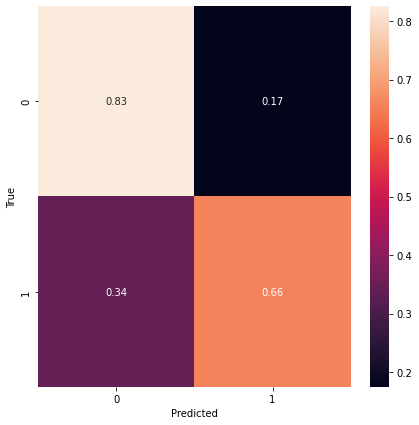

100%|██████████| 80/80 [00:15<00:00,  5.29it/s]


VALIDATION - Time: 15.2s - Loss: 0.47591550387442094


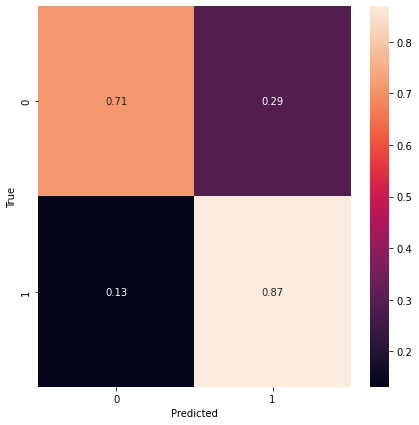

* Epoch 31 / 95


100%|██████████| 372/372 [02:16<00:00,  2.72it/s]


TRAIN - Time: 136.7s - Loss: 0.5047625809988023


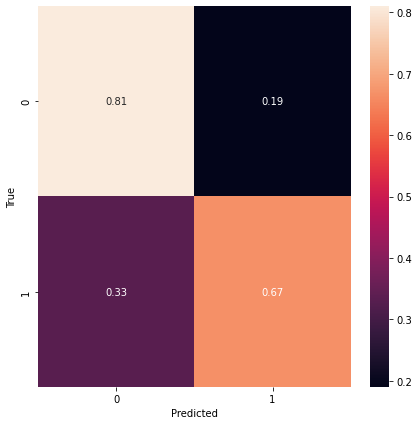

100%|██████████| 80/80 [00:15<00:00,  5.13it/s]


VALIDATION - Time: 15.6s - Loss: 0.45312868803739537


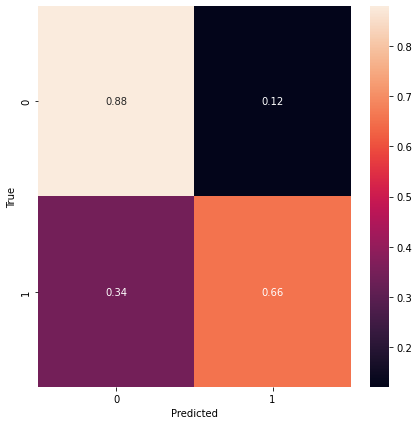

* Epoch 32 / 95


100%|██████████| 372/372 [02:17<00:00,  2.71it/s]


TRAIN - Time: 137.1s - Loss: 0.5083699046123413


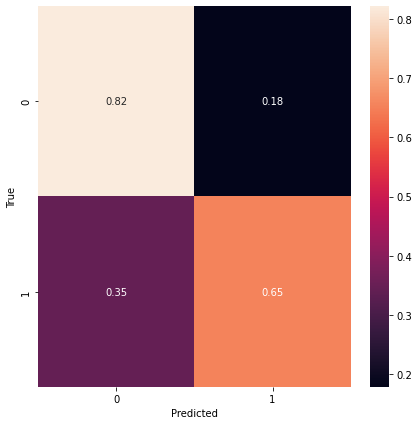

100%|██████████| 80/80 [00:15<00:00,  5.10it/s]


VALIDATION - Time: 15.7s - Loss: 0.46747723836451777


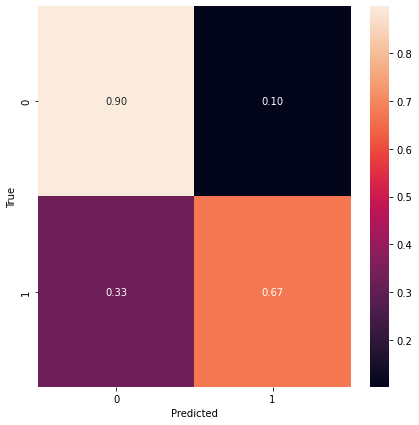

* Epoch 33 / 95


100%|██████████| 372/372 [02:18<00:00,  2.69it/s]


TRAIN - Time: 138.2s - Loss: 0.5080950909083891


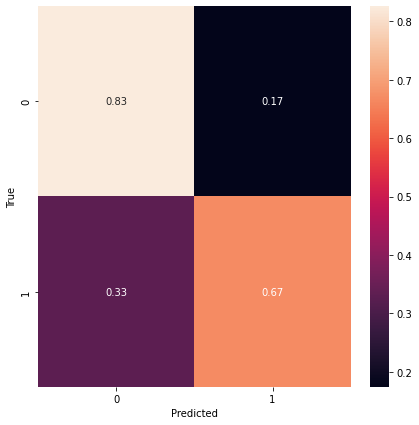

100%|██████████| 80/80 [00:15<00:00,  5.03it/s]


VALIDATION - Time: 15.9s - Loss: 0.42993374783545724


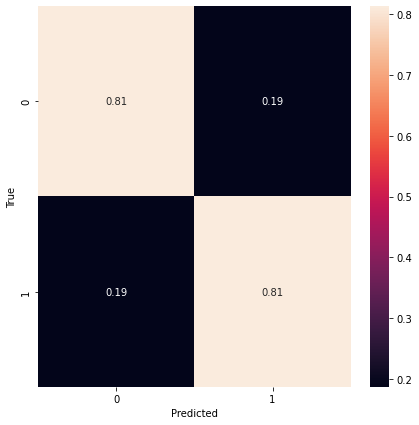

* Epoch 34 / 95


100%|██████████| 372/372 [02:09<00:00,  2.88it/s]


TRAIN - Time: 129.0s - Loss: 0.5023850102418213


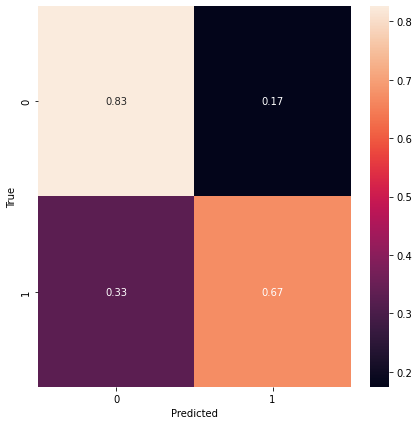

100%|██████████| 80/80 [00:14<00:00,  5.56it/s]


VALIDATION - Time: 14.4s - Loss: 0.4767599450424313


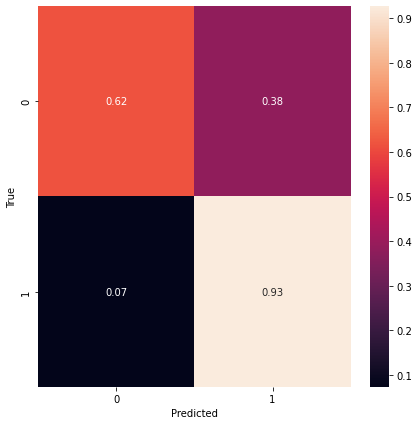

* Epoch 35 / 95


100%|██████████| 372/372 [02:19<00:00,  2.67it/s]


TRAIN - Time: 139.1s - Loss: 0.49564010265373426


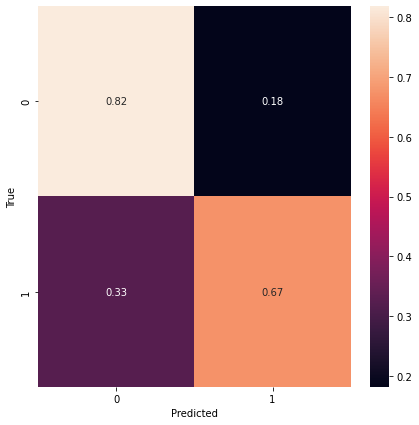

100%|██████████| 80/80 [00:16<00:00,  5.00it/s]


VALIDATION - Time: 16.0s - Loss: 0.4502856103703381


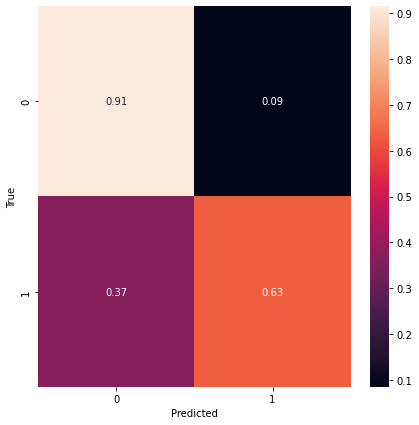

* Epoch 36 / 95


100%|██████████| 372/372 [02:19<00:00,  2.67it/s]


TRAIN - Time: 139.1s - Loss: 0.4955644277875786


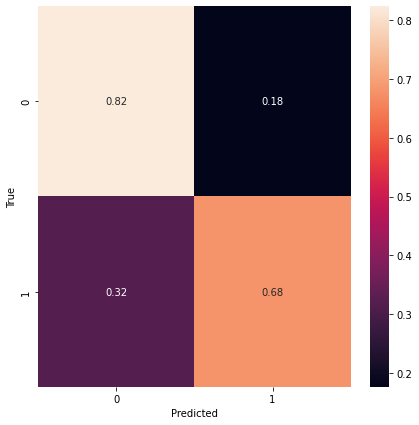

100%|██████████| 80/80 [00:17<00:00,  4.63it/s]


VALIDATION - Time: 17.3s - Loss: 0.435486895777285


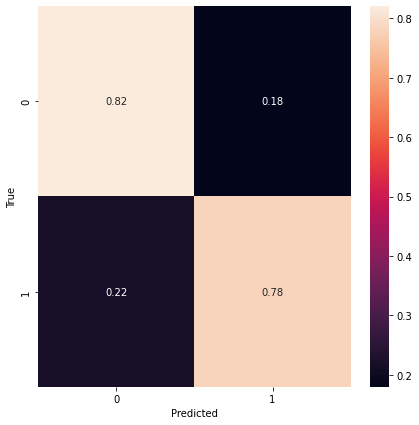

* Epoch 37 / 95


100%|██████████| 372/372 [02:22<00:00,  2.61it/s]


TRAIN - Time: 142.6s - Loss: 0.4932509085904526


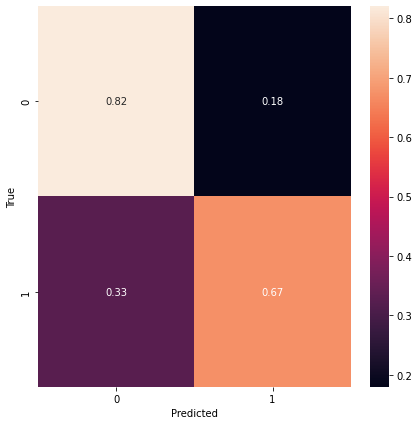

100%|██████████| 80/80 [00:16<00:00,  4.87it/s]


VALIDATION - Time: 16.4s - Loss: 0.4397209491580727


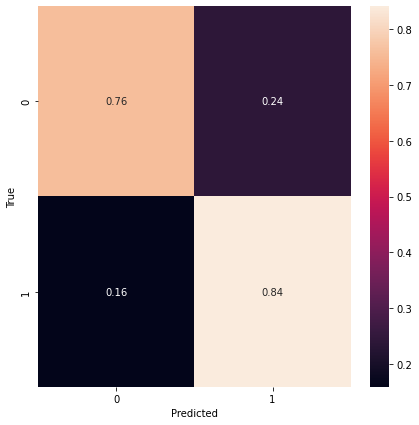

* Epoch 38 / 95


100%|██████████| 372/372 [02:08<00:00,  2.90it/s]


TRAIN - Time: 128.2s - Loss: 0.5014635921726308


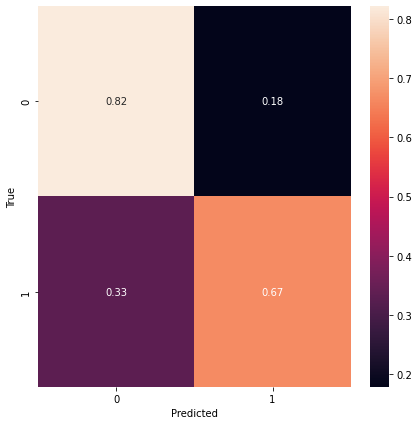

100%|██████████| 80/80 [00:14<00:00,  5.68it/s]


VALIDATION - Time: 14.1s - Loss: 0.45032465774565933


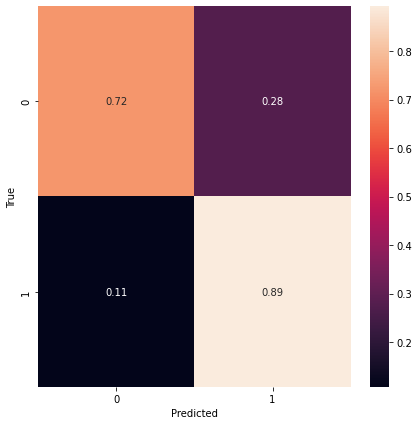

* Epoch 39 / 95


100%|██████████| 372/372 [02:11<00:00,  2.83it/s]


TRAIN - Time: 131.4s - Loss: 0.49771564790318074


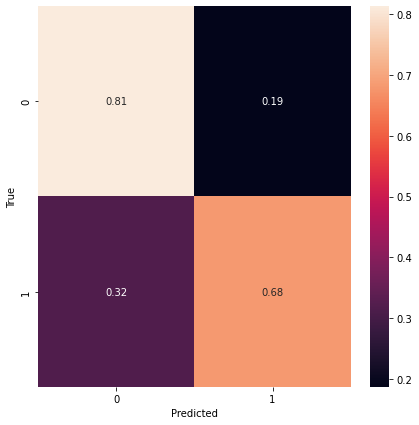

100%|██████████| 80/80 [00:14<00:00,  5.37it/s]


VALIDATION - Time: 14.9s - Loss: 0.4539417374879121


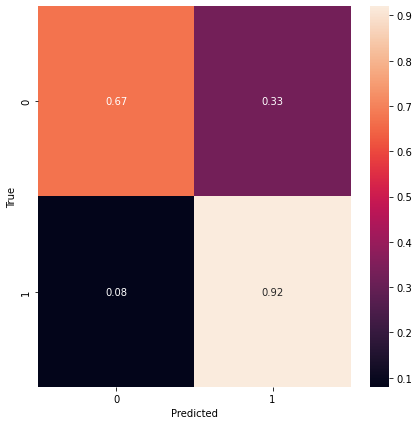

* Epoch 40 / 95


100%|██████████| 372/372 [02:12<00:00,  2.81it/s]


TRAIN - Time: 132.2s - Loss: 0.49384481343691033


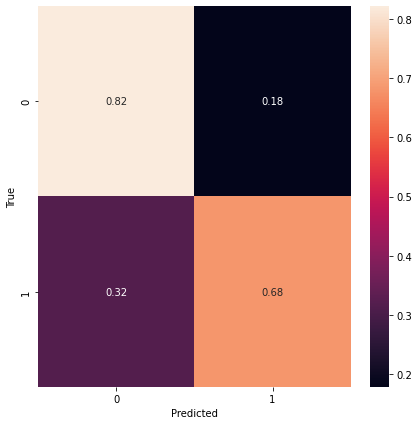

100%|██████████| 80/80 [00:15<00:00,  5.28it/s]


VALIDATION - Time: 15.2s - Loss: 0.46235218122601496


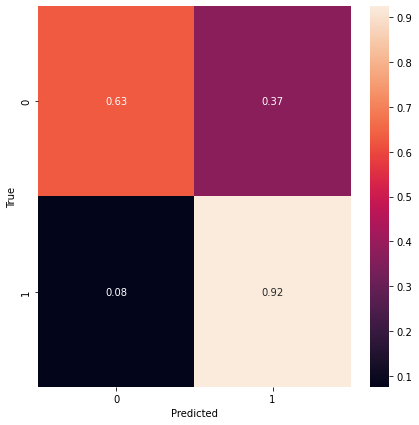

* Epoch 41 / 95


100%|██████████| 372/372 [02:17<00:00,  2.70it/s]


TRAIN - Time: 137.7s - Loss: 0.4881888257479798


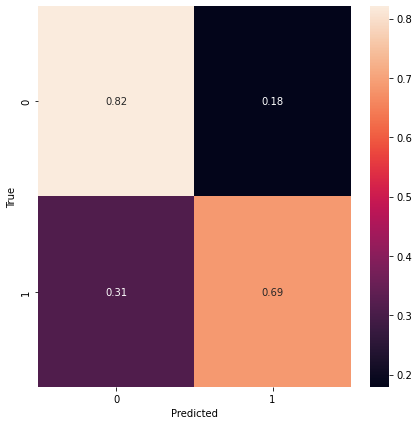

100%|██████████| 80/80 [00:15<00:00,  5.05it/s]


VALIDATION - Time: 15.9s - Loss: 0.4070013806223869


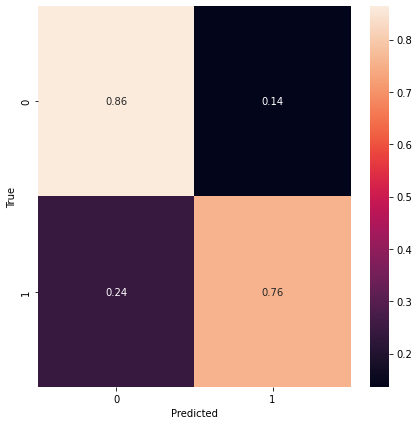

* Epoch 42 / 95


100%|██████████| 372/372 [02:20<00:00,  2.64it/s]


TRAIN - Time: 141.0s - Loss: 0.49197915056219677


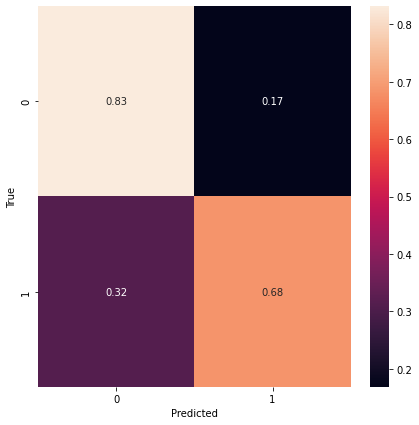

100%|██████████| 80/80 [00:16<00:00,  4.94it/s]


VALIDATION - Time: 16.2s - Loss: 0.4389780100435018


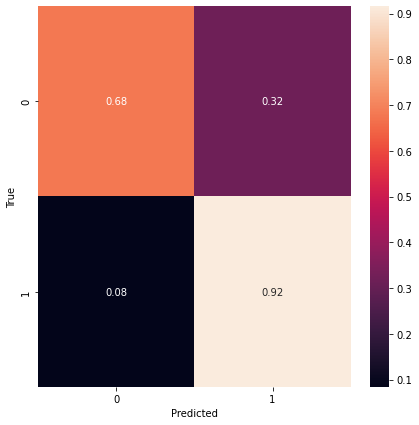

* Epoch 43 / 95


100%|██████████| 372/372 [02:22<00:00,  2.62it/s]


TRAIN - Time: 142.1s - Loss: 0.4926924846505606


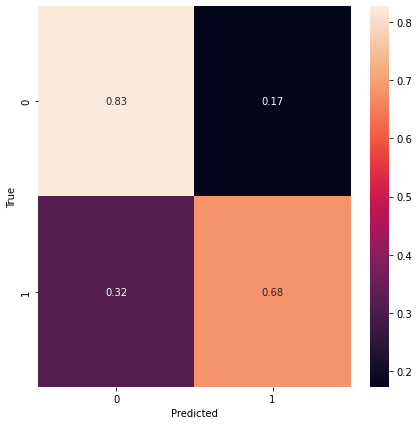

100%|██████████| 80/80 [00:16<00:00,  4.83it/s]


VALIDATION - Time: 16.6s - Loss: 0.41773749049752956


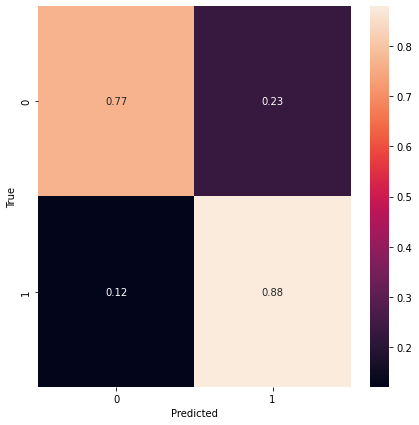

* Epoch 44 / 95


100%|██████████| 372/372 [02:22<00:00,  2.61it/s]


TRAIN - Time: 142.5s - Loss: 0.48857729829927893


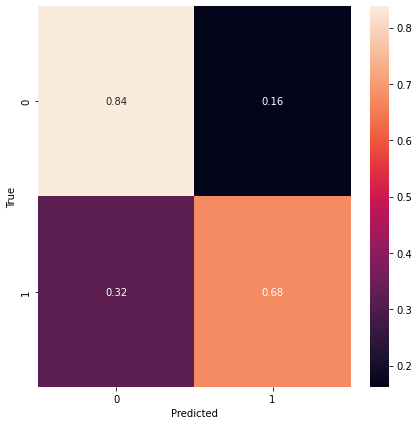

100%|██████████| 80/80 [00:17<00:00,  4.69it/s]


VALIDATION - Time: 17.1s - Loss: 0.42090249825268977


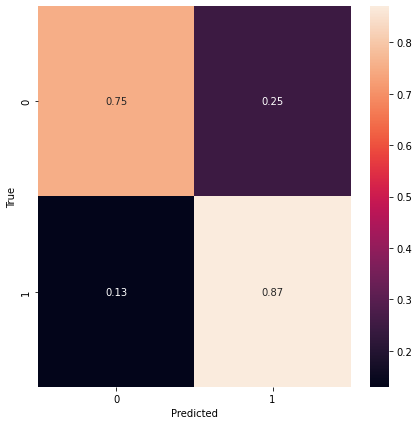

* Epoch 45 / 95


100%|██████████| 372/372 [02:22<00:00,  2.61it/s]


TRAIN - Time: 142.7s - Loss: 0.49004265345552894


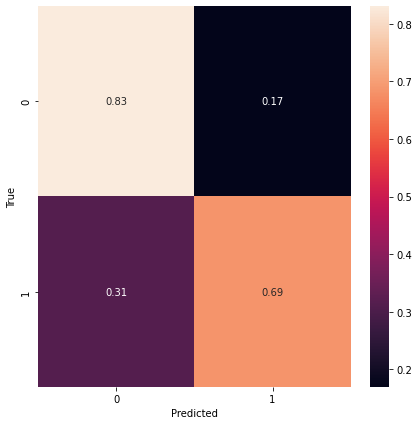

100%|██████████| 80/80 [00:16<00:00,  4.82it/s]


VALIDATION - Time: 16.6s - Loss: 0.4216191025450826


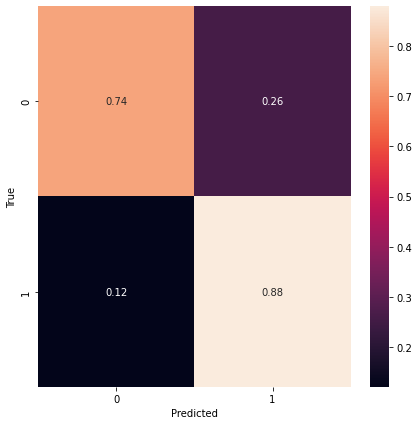

* Epoch 46 / 95


100%|██████████| 372/372 [02:19<00:00,  2.67it/s]


TRAIN - Time: 139.4s - Loss: 0.4945544622518041


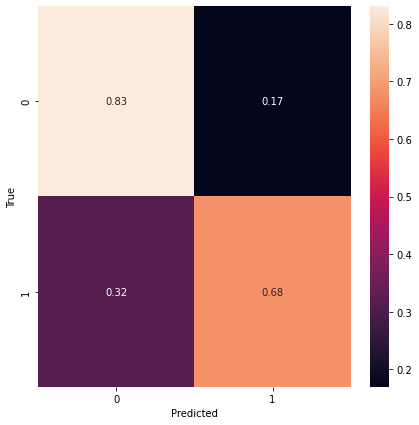

100%|██████████| 80/80 [00:16<00:00,  4.87it/s]


VALIDATION - Time: 16.4s - Loss: 0.42095101270824675


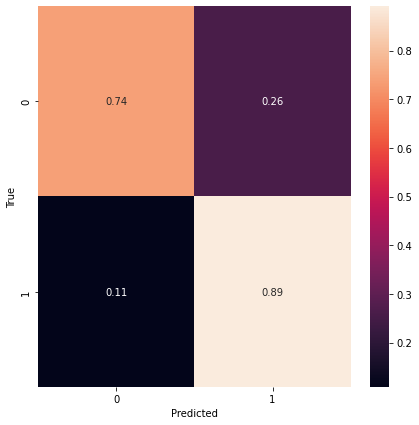

* Epoch 47 / 95


100%|██████████| 372/372 [02:16<00:00,  2.72it/s]


TRAIN - Time: 137.0s - Loss: 0.48661739551412153


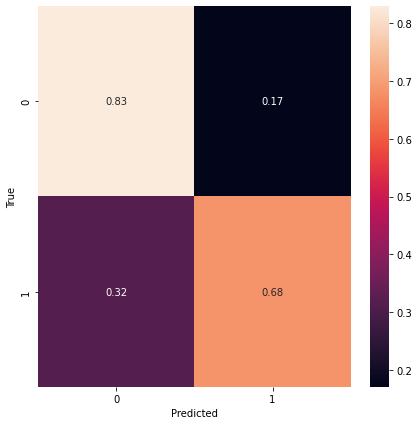

100%|██████████| 80/80 [00:15<00:00,  5.06it/s]


VALIDATION - Time: 15.8s - Loss: 0.4483860354870558


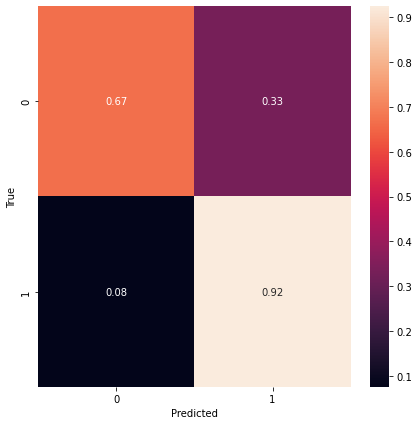

* Epoch 48 / 95


100%|██████████| 372/372 [02:20<00:00,  2.65it/s]


TRAIN - Time: 140.3s - Loss: 0.4932095555448403


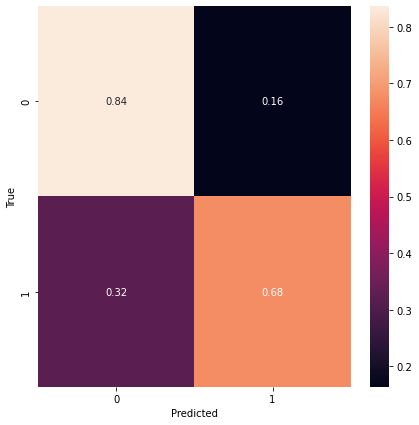

100%|██████████| 80/80 [00:15<00:00,  5.02it/s]


VALIDATION - Time: 15.9s - Loss: 0.4399424012750388


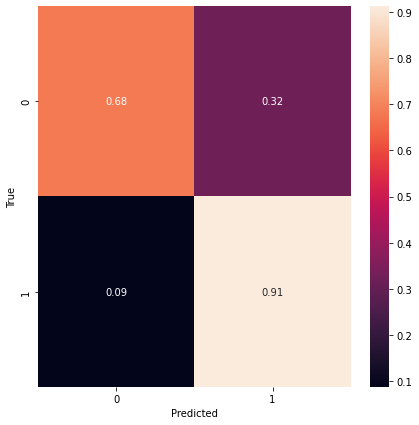

* Epoch 49 / 95


100%|██████████| 372/372 [02:19<00:00,  2.66it/s]


TRAIN - Time: 139.7s - Loss: 0.4861868023071239


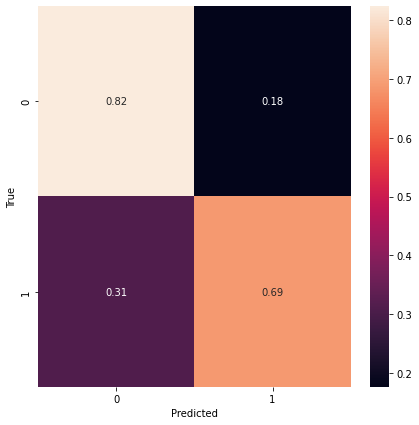

100%|██████████| 80/80 [00:16<00:00,  4.97it/s]


VALIDATION - Time: 16.1s - Loss: 0.40038004461675886


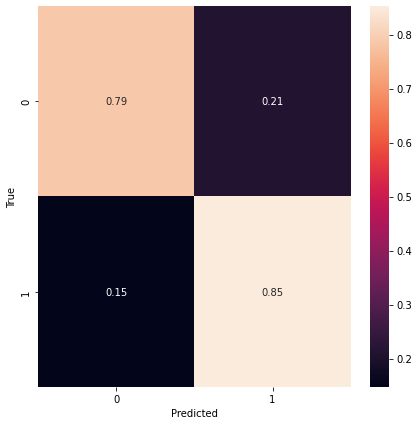

* Epoch 50 / 95


100%|██████████| 372/372 [02:17<00:00,  2.70it/s]


TRAIN - Time: 138.0s - Loss: 0.48294977222879726


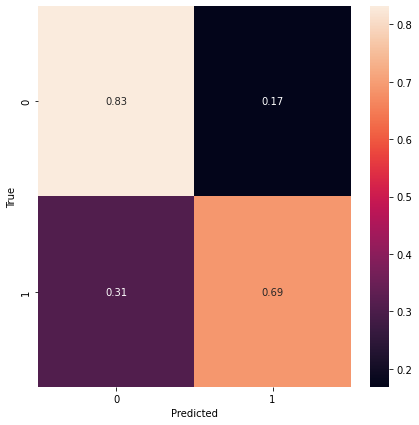

100%|██████████| 80/80 [00:17<00:00,  4.67it/s]


VALIDATION - Time: 17.1s - Loss: 0.4014900982379912


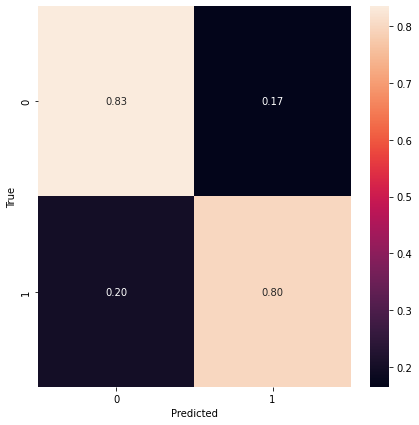

* Epoch 51 / 95


100%|██████████| 372/372 [02:17<00:00,  2.70it/s]


TRAIN - Time: 137.7s - Loss: 0.4875642866777476


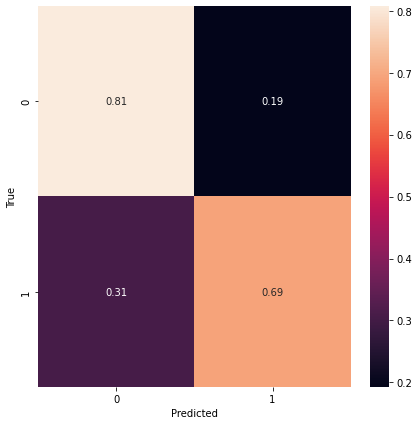

100%|██████████| 80/80 [00:16<00:00,  4.95it/s]


VALIDATION - Time: 16.2s - Loss: 0.43393613677471865


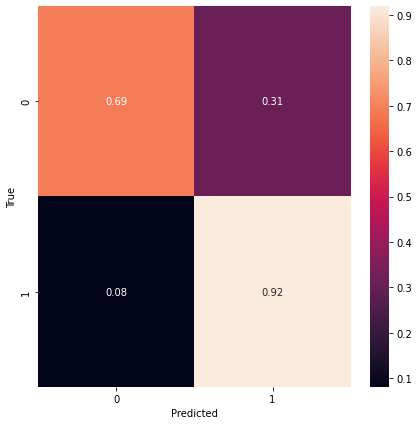

* Epoch 52 / 95


100%|██████████| 372/372 [02:18<00:00,  2.68it/s]


TRAIN - Time: 138.9s - Loss: 0.48749672389158644


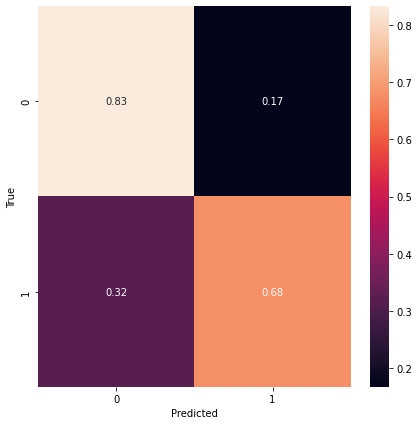

100%|██████████| 80/80 [00:16<00:00,  4.93it/s]


VALIDATION - Time: 16.2s - Loss: 0.4054006181657314


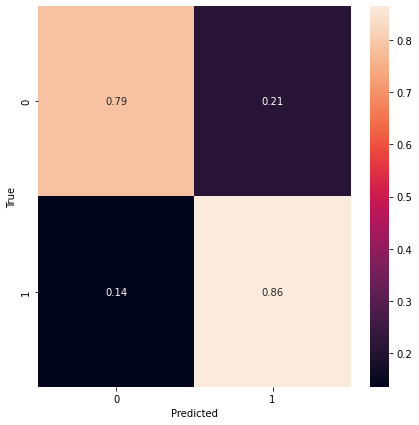

* Epoch 53 / 95


100%|██████████| 372/372 [02:19<00:00,  2.66it/s]


TRAIN - Time: 139.8s - Loss: 0.48983675177379293


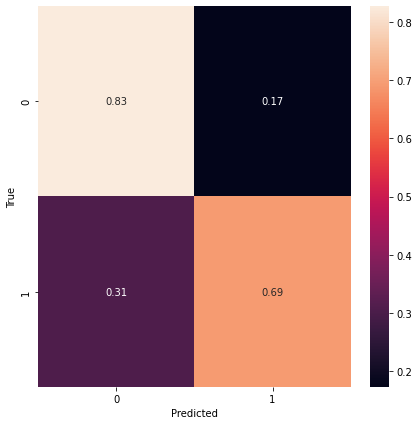

100%|██████████| 80/80 [00:16<00:00,  4.91it/s]


VALIDATION - Time: 16.3s - Loss: 0.43139696735888733


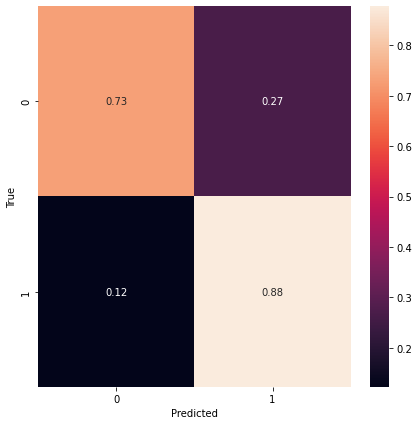

* Epoch 54 / 95


100%|██████████| 372/372 [02:21<00:00,  2.63it/s]


TRAIN - Time: 141.3s - Loss: 0.49353096926564854


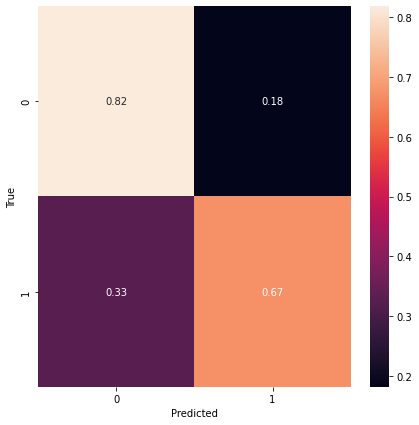

100%|██████████| 80/80 [00:16<00:00,  4.90it/s]


VALIDATION - Time: 16.3s - Loss: 0.417377068847418


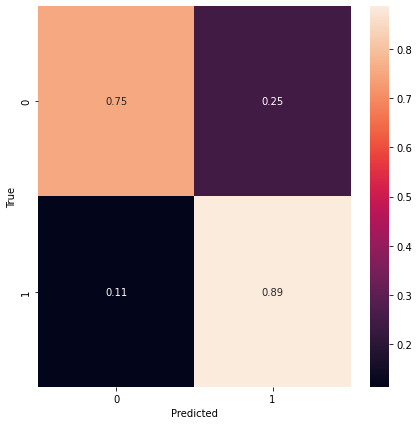

* Epoch 55 / 95


100%|██████████| 372/372 [02:19<00:00,  2.66it/s]


TRAIN - Time: 139.9s - Loss: 0.4708700052672817


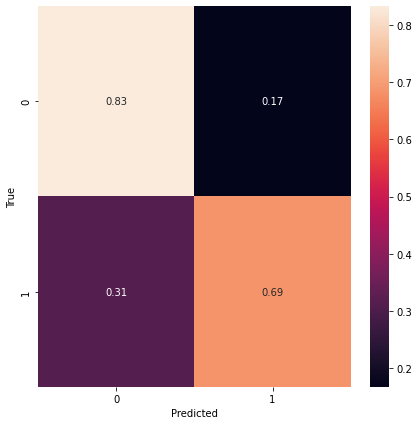

100%|██████████| 80/80 [00:16<00:00,  4.87it/s]


VALIDATION - Time: 16.4s - Loss: 0.4051249494776129


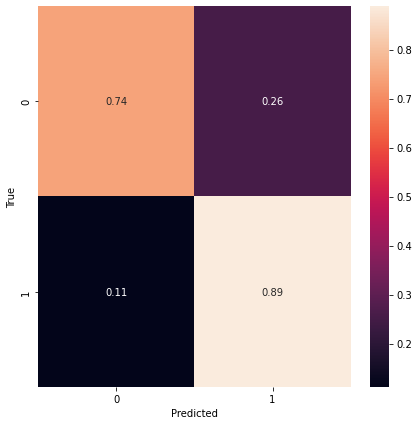

* Epoch 56 / 95


100%|██████████| 372/372 [02:16<00:00,  2.73it/s]


TRAIN - Time: 136.1s - Loss: 0.4807937633126014


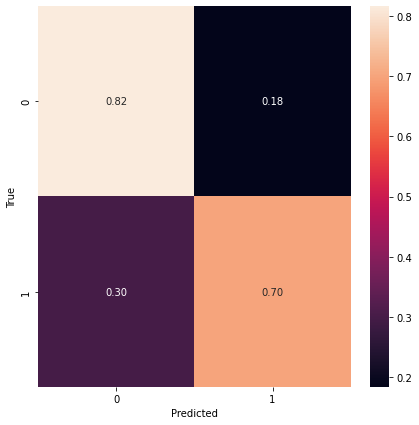

100%|██████████| 80/80 [00:15<00:00,  5.23it/s]


VALIDATION - Time: 15.3s - Loss: 0.40583879109472026


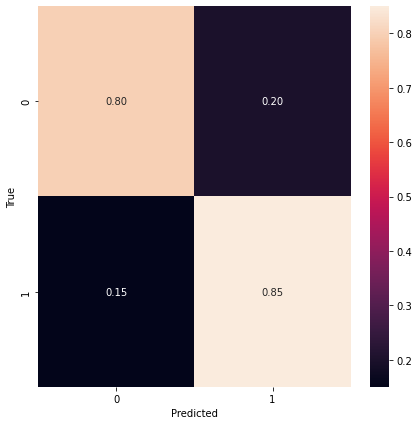

* Epoch 57 / 95


100%|██████████| 372/372 [02:17<00:00,  2.71it/s]


TRAIN - Time: 137.5s - Loss: 0.4769217691594558


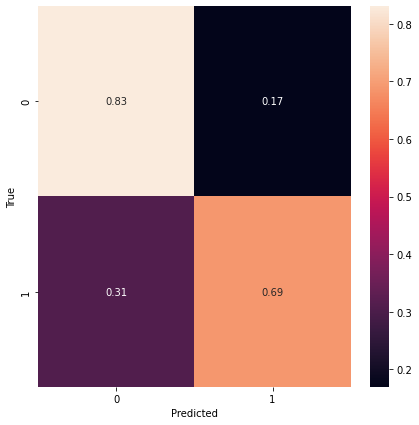

100%|██████████| 80/80 [00:15<00:00,  5.11it/s]


VALIDATION - Time: 15.7s - Loss: 0.46726918946951623


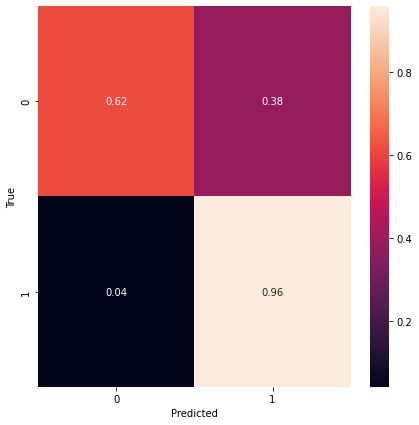

* Epoch 58 / 95


100%|██████████| 372/372 [02:18<00:00,  2.68it/s]


TRAIN - Time: 138.6s - Loss: 0.4742403827928087


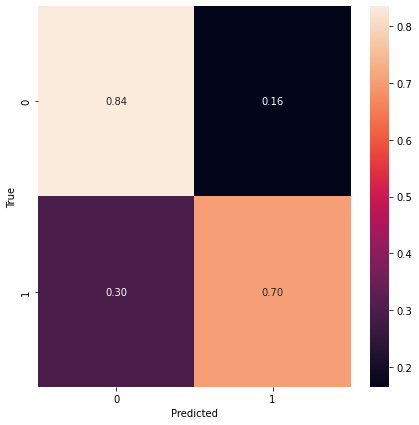

100%|██████████| 80/80 [00:15<00:00,  5.05it/s]


VALIDATION - Time: 15.8s - Loss: 0.396691177226603


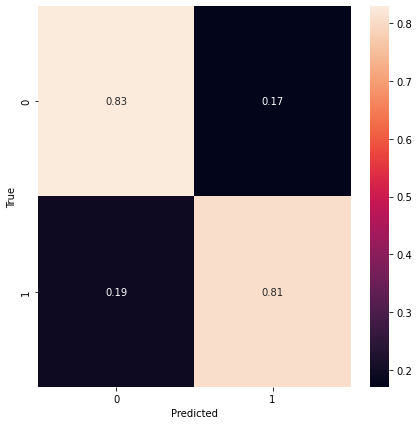

* Epoch 59 / 95


100%|██████████| 372/372 [02:19<00:00,  2.68it/s]


TRAIN - Time: 139.1s - Loss: 0.48249348369176637


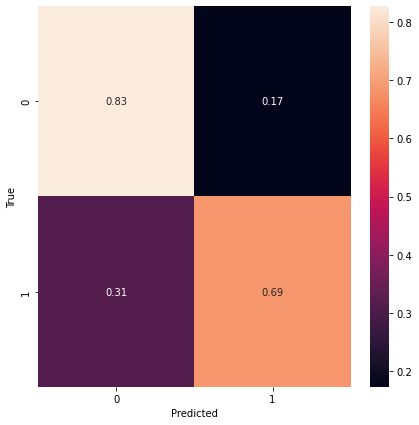

100%|██████████| 80/80 [00:17<00:00,  4.63it/s]

VALIDATION - Time: 17.3s - Loss: 0.46708012558519846


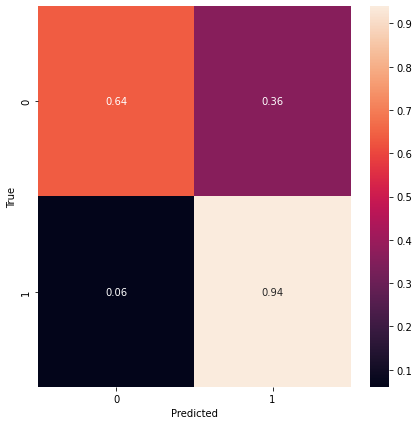

* Epoch 60 / 95


100%|██████████| 372/372 [02:18<00:00,  2.68it/s]


TRAIN - Time: 138.8s - Loss: 0.471806109151853


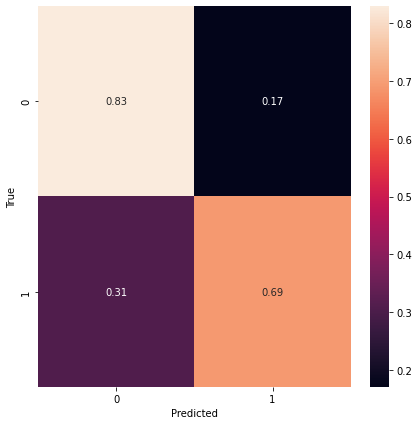

100%|██████████| 80/80 [00:16<00:00,  4.92it/s]


VALIDATION - Time: 16.3s - Loss: 0.3984593568369747


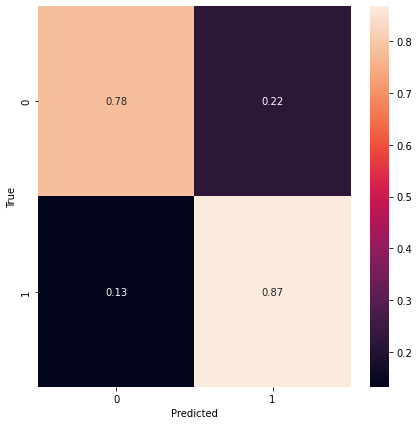

* Epoch 61 / 95


100%|██████████| 372/372 [02:19<00:00,  2.66it/s]


TRAIN - Time: 139.9s - Loss: 0.4781989468441853


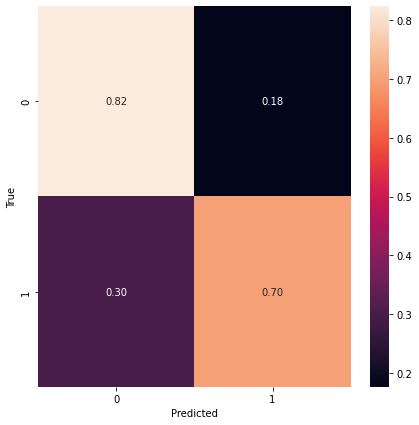

100%|██████████| 80/80 [00:16<00:00,  4.85it/s]


VALIDATION - Time: 16.5s - Loss: 0.40774134974926696


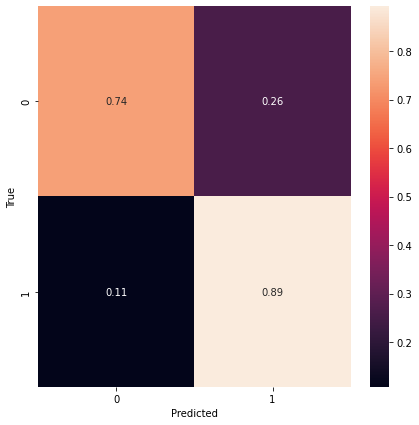

* Epoch 62 / 95


100%|██████████| 372/372 [02:21<00:00,  2.63it/s]


TRAIN - Time: 141.4s - Loss: 0.4734609580088047


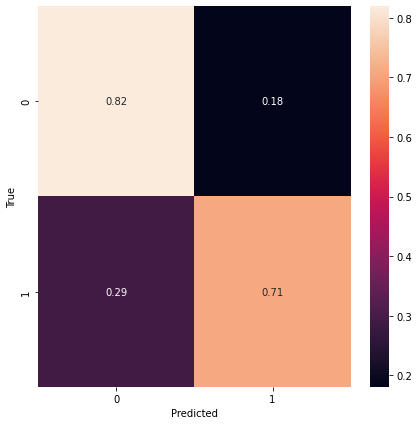

100%|██████████| 80/80 [00:16<00:00,  4.87it/s]


VALIDATION - Time: 16.5s - Loss: 0.3968495965003968


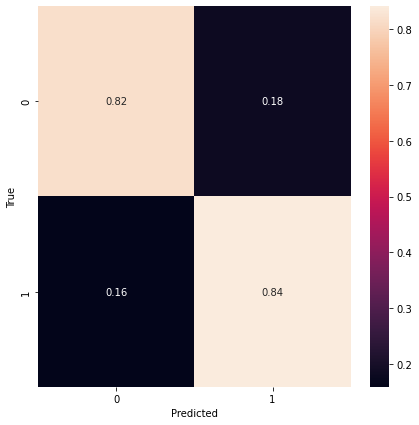

* Epoch 63 / 95


100%|██████████| 372/372 [02:19<00:00,  2.67it/s]


TRAIN - Time: 139.4s - Loss: 0.4692537285868197


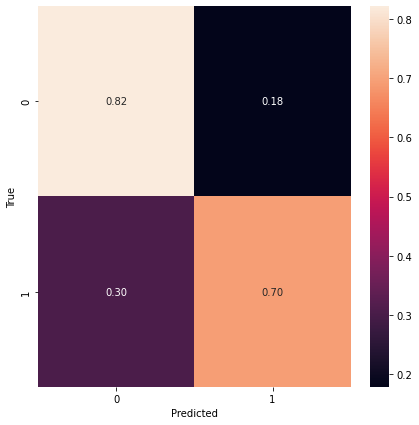

100%|██████████| 80/80 [00:16<00:00,  4.85it/s]


VALIDATION - Time: 16.5s - Loss: 0.4768959349021315


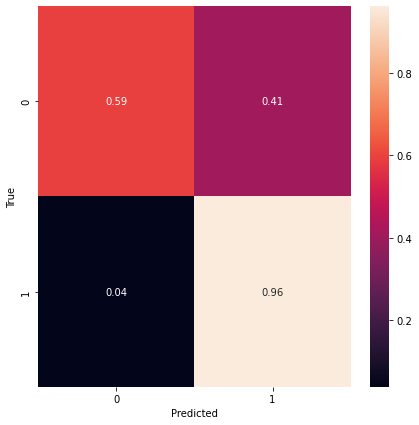

* Epoch 64 / 95


100%|██████████| 372/372 [02:21<00:00,  2.63it/s]


TRAIN - Time: 141.3s - Loss: 0.48167611726669873


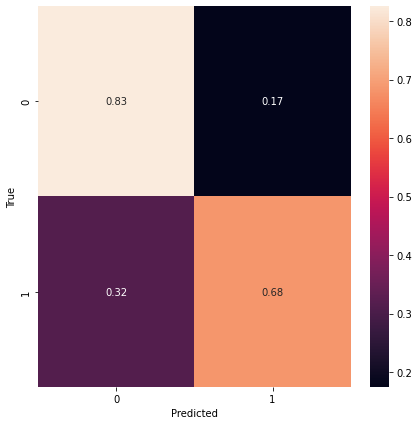

100%|██████████| 80/80 [00:16<00:00,  4.82it/s]


VALIDATION - Time: 16.6s - Loss: 0.3904103297740222


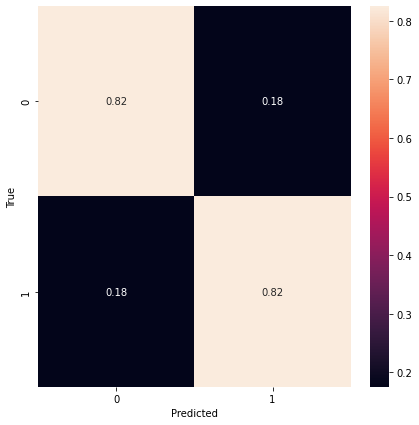

* Epoch 65 / 95


100%|██████████| 372/372 [02:18<00:00,  2.69it/s]


TRAIN - Time: 138.5s - Loss: 0.4630083708913737


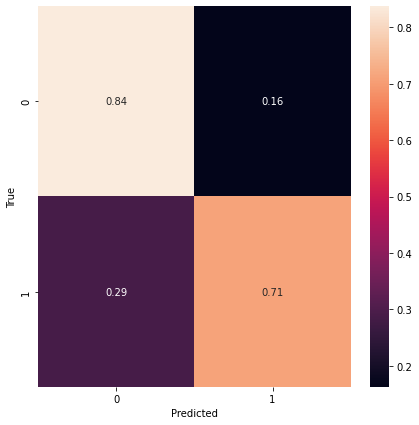

100%|██████████| 80/80 [00:15<00:00,  5.13it/s]


VALIDATION - Time: 15.6s - Loss: 0.4008602587506176


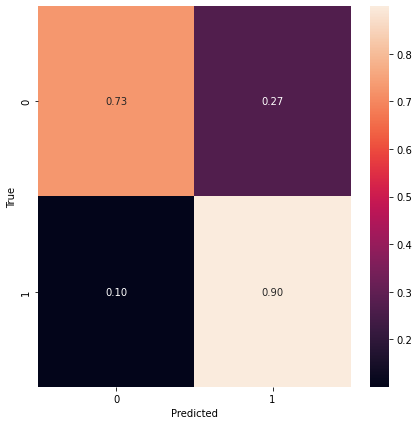

* Epoch 66 / 95


100%|██████████| 372/372 [02:18<00:00,  2.69it/s]


TRAIN - Time: 138.1s - Loss: 0.46780373460503


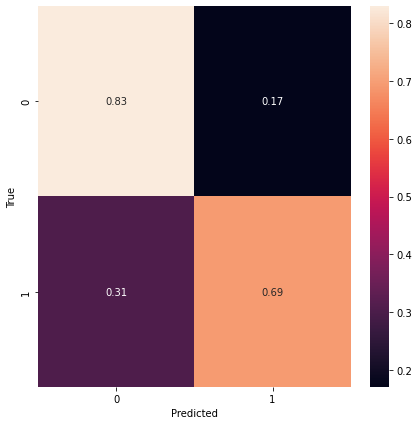

100%|██████████| 80/80 [00:15<00:00,  5.07it/s]


VALIDATION - Time: 15.8s - Loss: 0.4288760593160986


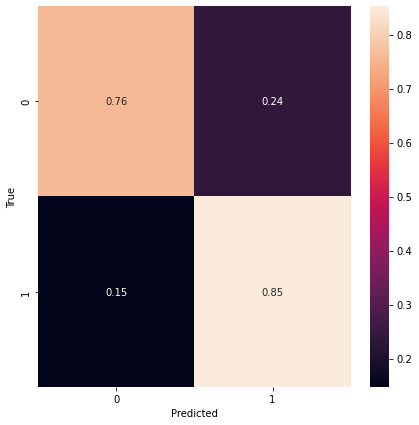

* Epoch 67 / 95


100%|██████████| 372/372 [02:18<00:00,  2.69it/s]


TRAIN - Time: 138.1s - Loss: 0.4714541837012257


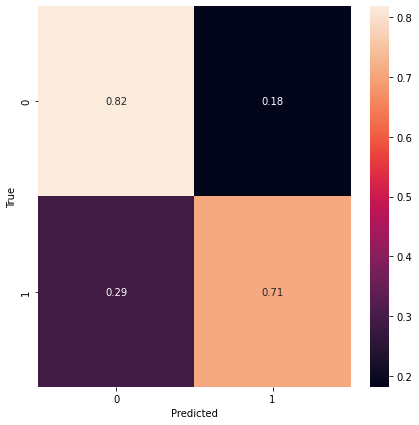

100%|██████████| 80/80 [00:16<00:00,  4.94it/s]


VALIDATION - Time: 16.2s - Loss: 0.4533281343057752


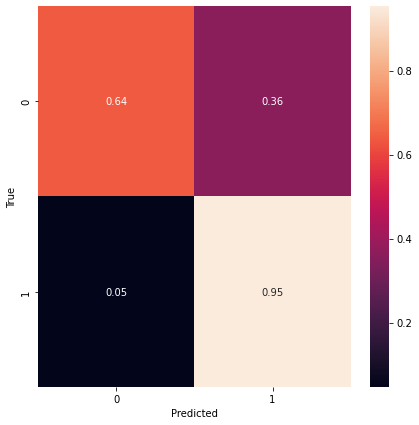

* Epoch 68 / 95


100%|██████████| 372/372 [02:17<00:00,  2.70it/s]


TRAIN - Time: 137.8s - Loss: 0.4603716867665451


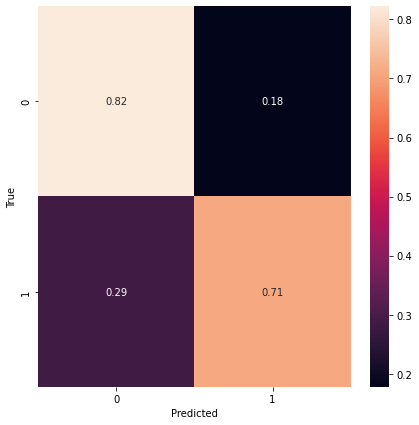

100%|██████████| 80/80 [00:16<00:00,  4.97it/s]


VALIDATION - Time: 16.1s - Loss: 0.450509798899293


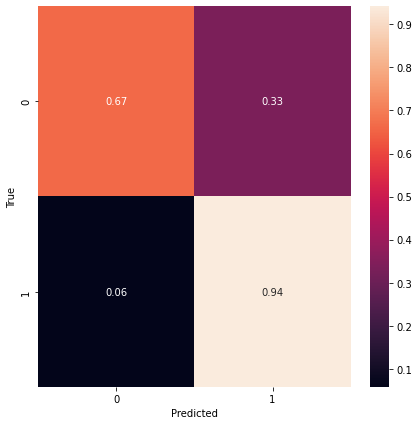

* Epoch 69 / 95


100%|██████████| 372/372 [02:19<00:00,  2.67it/s]


TRAIN - Time: 139.4s - Loss: 0.4701551777781337


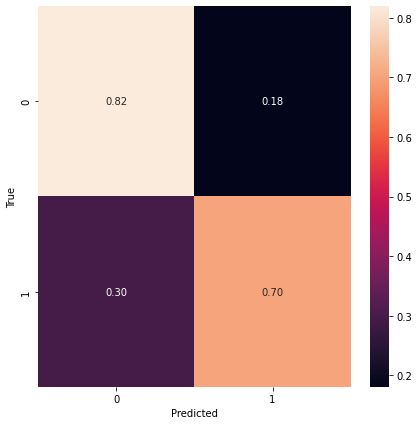

100%|██████████| 80/80 [00:16<00:00,  4.95it/s]


VALIDATION - Time: 16.2s - Loss: 0.3907128846272825


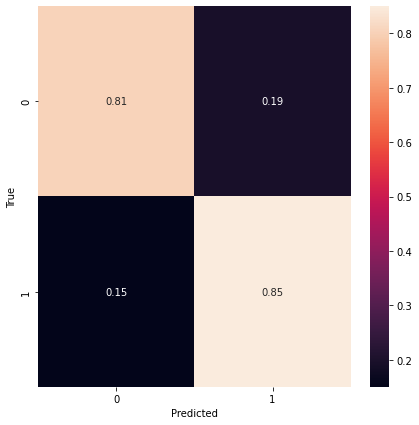

* Epoch 70 / 95


100%|██████████| 372/372 [02:21<00:00,  2.63it/s]


TRAIN - Time: 141.4s - Loss: 0.4674092157473489


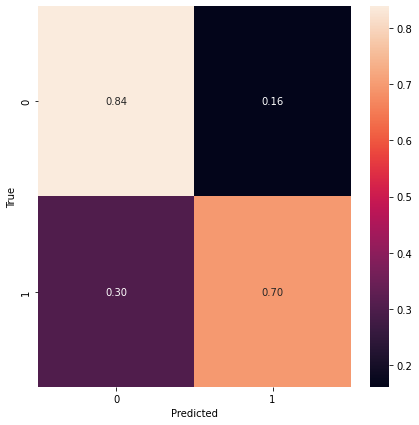

100%|██████████| 80/80 [00:16<00:00,  4.85it/s]


VALIDATION - Time: 16.5s - Loss: 0.3926990749314427


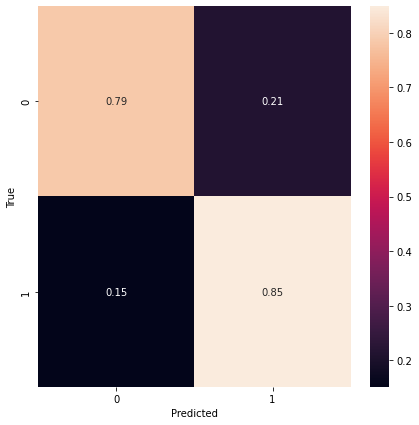

* Epoch 71 / 95


100%|██████████| 372/372 [02:23<00:00,  2.59it/s]


TRAIN - Time: 143.7s - Loss: 0.4696354281597881


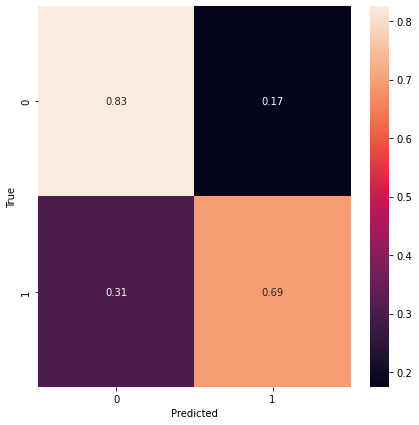

100%|██████████| 80/80 [00:16<00:00,  4.76it/s]


VALIDATION - Time: 16.8s - Loss: 0.3996838118880987


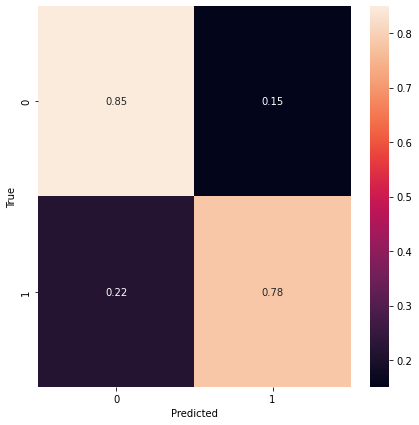

* Epoch 72 / 95


100%|██████████| 372/372 [02:18<00:00,  2.68it/s]


TRAIN - Time: 138.6s - Loss: 0.45897955279196473


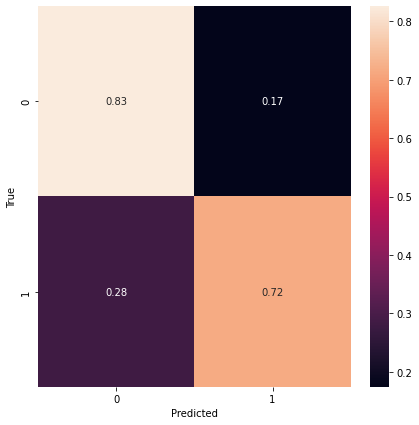

100%|██████████| 80/80 [00:16<00:00,  4.80it/s]


VALIDATION - Time: 16.7s - Loss: 0.3981755934655667


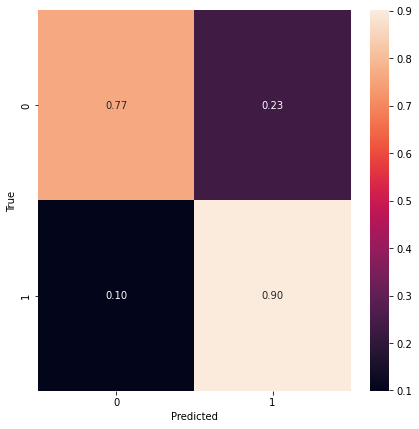

* Epoch 73 / 95


100%|██████████| 372/372 [02:22<00:00,  2.62it/s]


TRAIN - Time: 142.0s - Loss: 0.46355532177834086


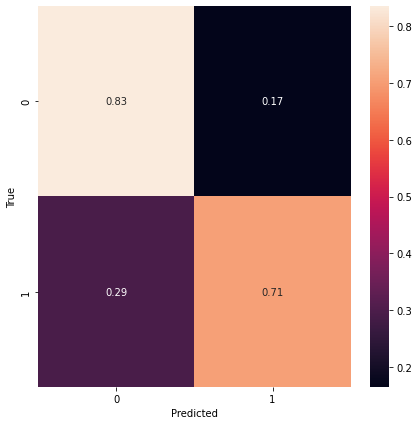

100%|██████████| 80/80 [00:16<00:00,  4.76it/s]


VALIDATION - Time: 16.8s - Loss: 0.39296284988522534


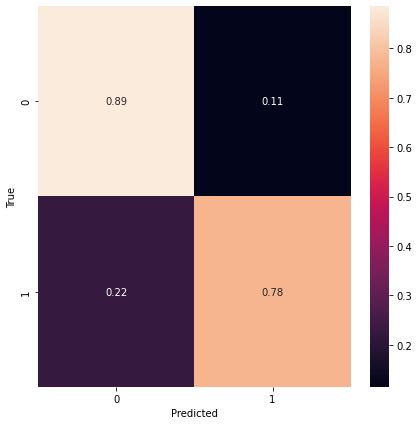

* Epoch 74 / 95


100%|██████████| 372/372 [02:17<00:00,  2.70it/s]


TRAIN - Time: 137.7s - Loss: 0.4599251410052659


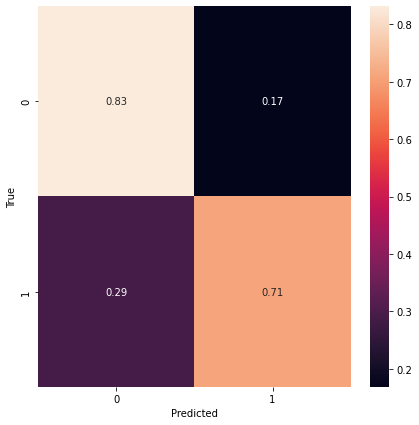

100%|██████████| 80/80 [00:14<00:00,  5.43it/s]


VALIDATION - Time: 14.7s - Loss: 0.40016177017241716


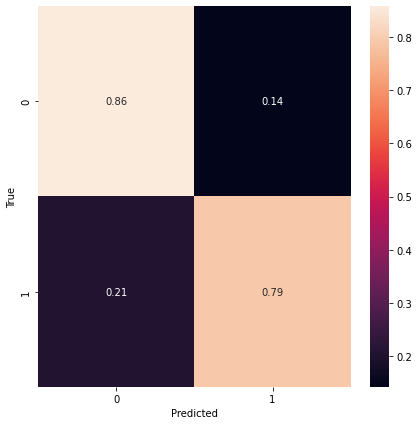

* Epoch 75 / 95


100%|██████████| 372/372 [02:13<00:00,  2.79it/s]


TRAIN - Time: 133.4s - Loss: 0.4632127684370803


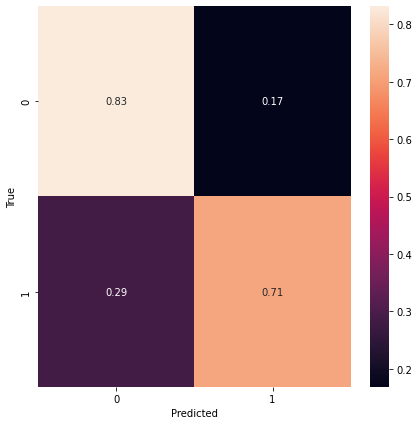

100%|██████████| 80/80 [00:14<00:00,  5.48it/s]


VALIDATION - Time: 14.6s - Loss: 0.3811667565256356


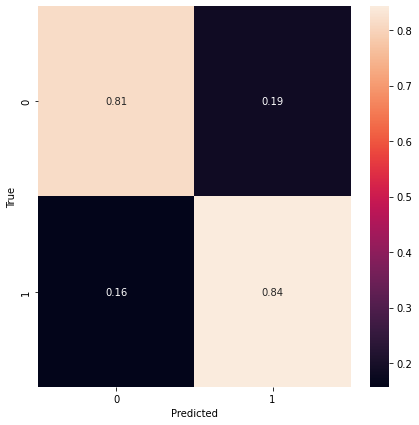

* Epoch 76 / 95


100%|██████████| 372/372 [02:15<00:00,  2.75it/s]


TRAIN - Time: 135.4s - Loss: 0.46488518143693597


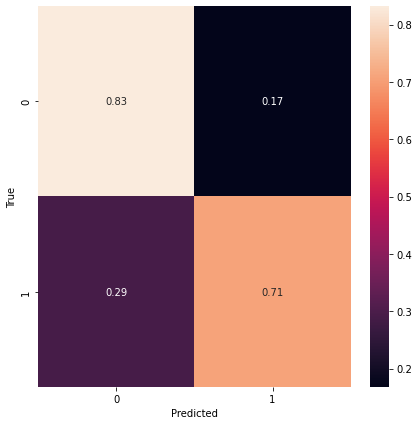

100%|██████████| 80/80 [00:14<00:00,  5.34it/s]


VALIDATION - Time: 15.0s - Loss: 0.4052532590925693


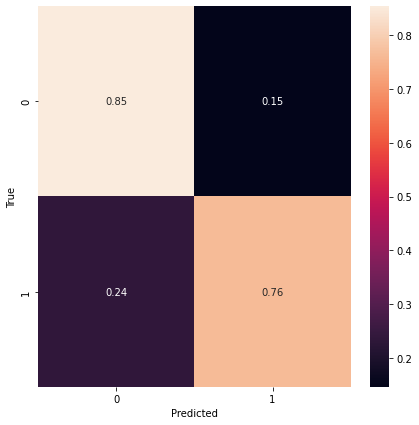

* Epoch 77 / 95


100%|██████████| 372/372 [02:14<00:00,  2.77it/s]


TRAIN - Time: 134.5s - Loss: 0.4709322851511738


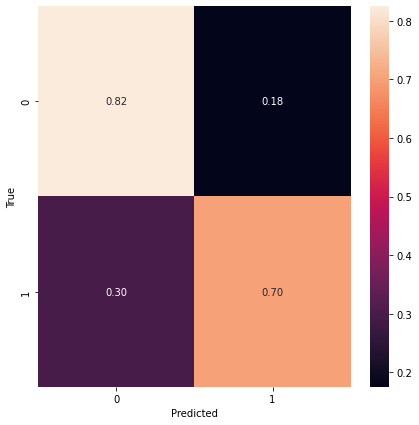

100%|██████████| 80/80 [00:15<00:00,  5.25it/s]


VALIDATION - Time: 15.2s - Loss: 0.3887307208031415


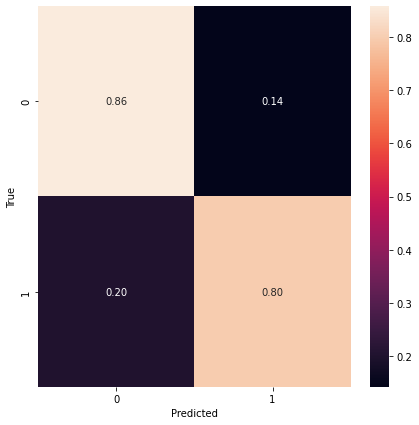

* Epoch 78 / 95


100%|██████████| 372/372 [02:14<00:00,  2.77it/s]


TRAIN - Time: 134.3s - Loss: 0.45856917985985346


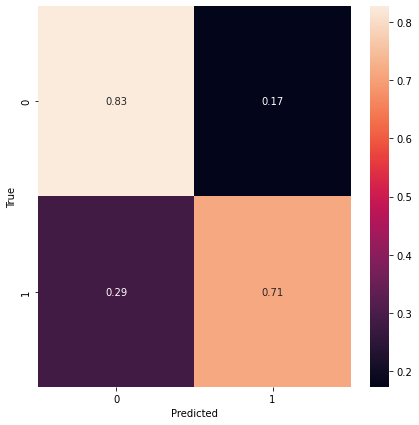

100%|██████████| 80/80 [00:15<00:00,  5.20it/s]


VALIDATION - Time: 15.4s - Loss: 0.40747075080871575


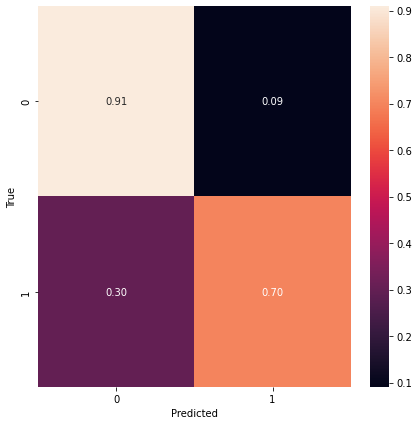

* Epoch 79 / 95


100%|██████████| 372/372 [02:16<00:00,  2.73it/s]


TRAIN - Time: 136.2s - Loss: 0.47103049113385154


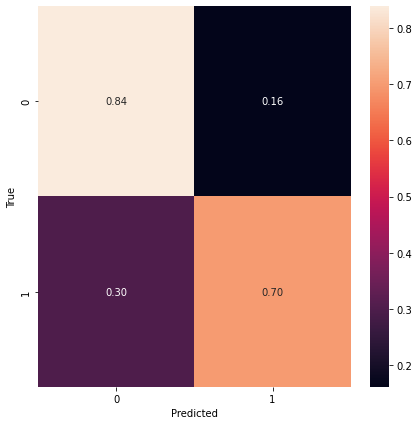

100%|██████████| 80/80 [00:15<00:00,  5.14it/s]


VALIDATION - Time: 15.6s - Loss: 0.37787316646426916


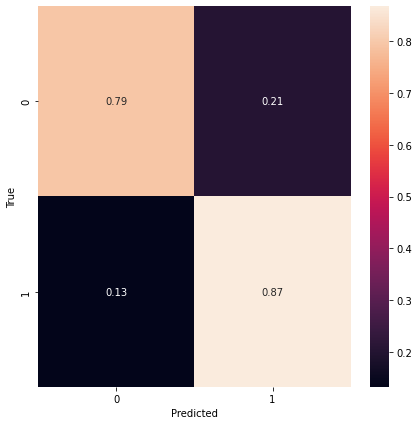

* Epoch 80 / 95


100%|██████████| 372/372 [02:17<00:00,  2.71it/s]


TRAIN - Time: 137.2s - Loss: 0.4546685727934041


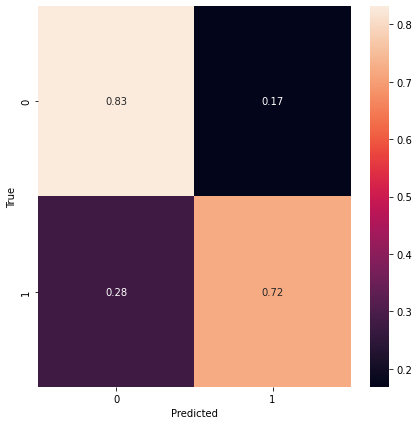

100%|██████████| 80/80 [00:15<00:00,  5.13it/s]


VALIDATION - Time: 15.6s - Loss: 0.4187299959361551


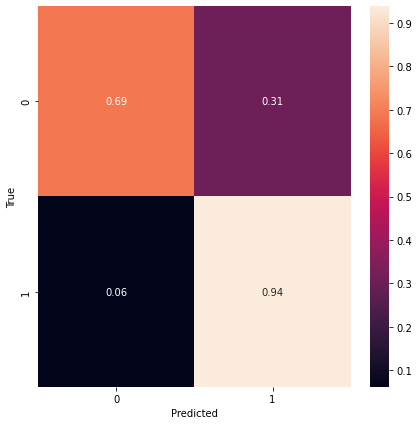

* Epoch 81 / 95


100%|██████████| 372/372 [02:10<00:00,  2.85it/s]


TRAIN - Time: 130.6s - Loss: 0.4569773125632476


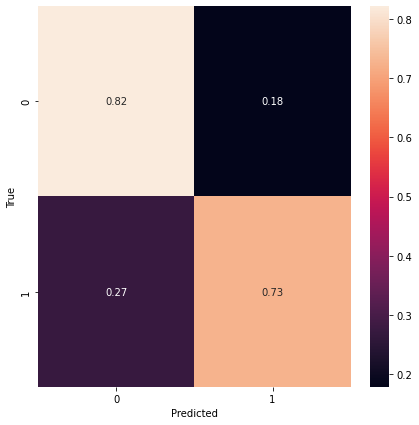

100%|██████████| 80/80 [00:15<00:00,  5.11it/s]


VALIDATION - Time: 15.7s - Loss: 0.3737639782950282


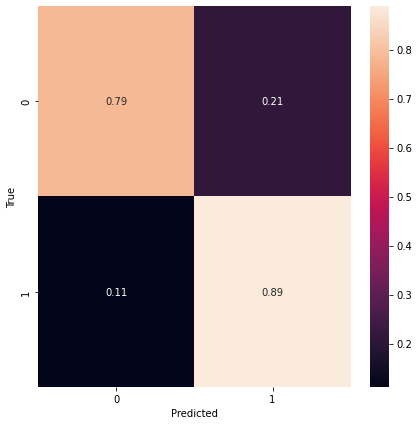

* Epoch 82 / 95


100%|██████████| 372/372 [02:17<00:00,  2.70it/s]


TRAIN - Time: 137.7s - Loss: 0.4530610353635843


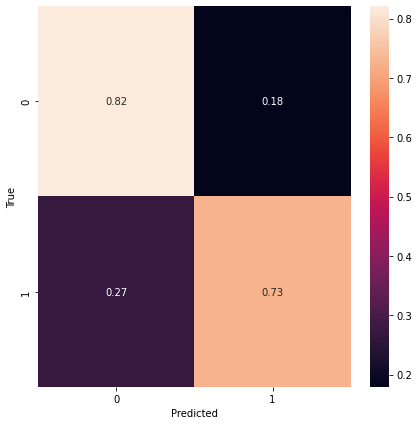

100%|██████████| 80/80 [00:15<00:00,  5.16it/s]


VALIDATION - Time: 15.5s - Loss: 0.4116504154168069


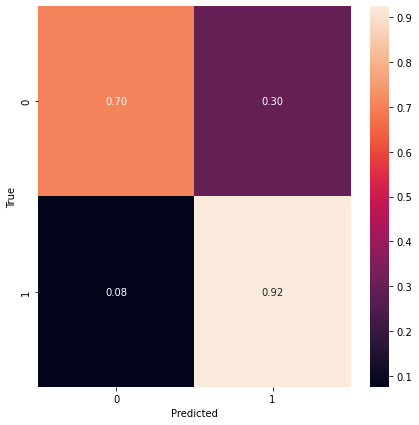

* Epoch 83 / 95


100%|██████████| 372/372 [02:12<00:00,  2.81it/s]


TRAIN - Time: 132.4s - Loss: 0.45824236276569535


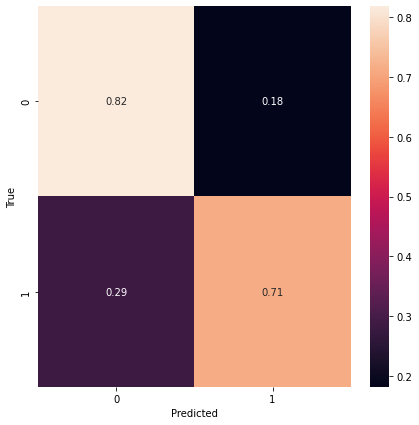

100%|██████████| 80/80 [00:14<00:00,  5.48it/s]


VALIDATION - Time: 14.6s - Loss: 0.37528643431141984


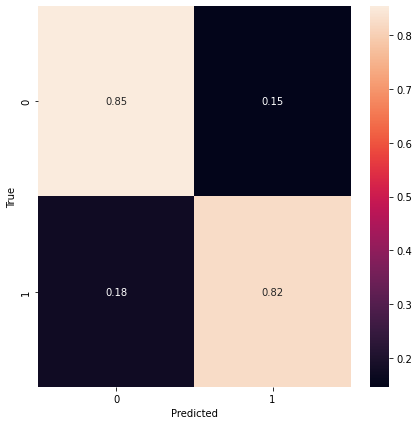

* Epoch 84 / 95


100%|██████████| 372/372 [02:11<00:00,  2.82it/s]


TRAIN - Time: 132.0s - Loss: 0.45689257707006237


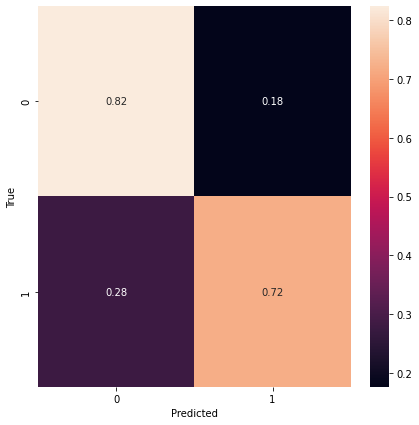

100%|██████████| 80/80 [00:14<00:00,  5.39it/s]


VALIDATION - Time: 14.9s - Loss: 0.3704947445541621


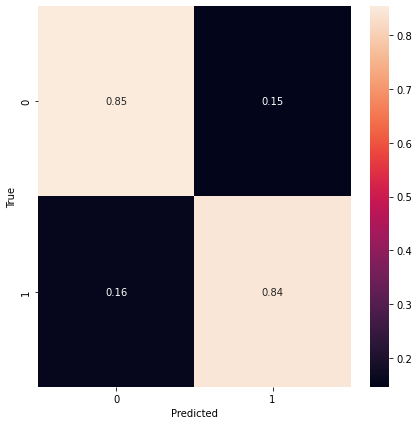

* Epoch 85 / 95


100%|██████████| 372/372 [02:13<00:00,  2.78it/s]


TRAIN - Time: 133.6s - Loss: 0.45282978063789764


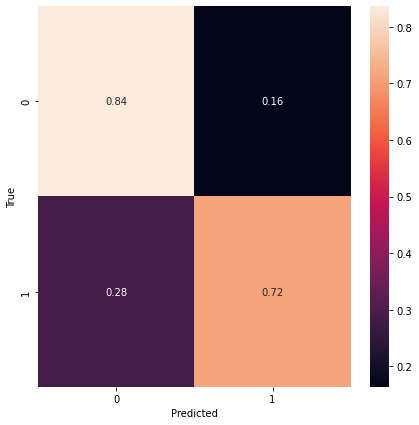

100%|██████████| 80/80 [00:14<00:00,  5.35it/s]


VALIDATION - Time: 15.0s - Loss: 0.38141157282516336


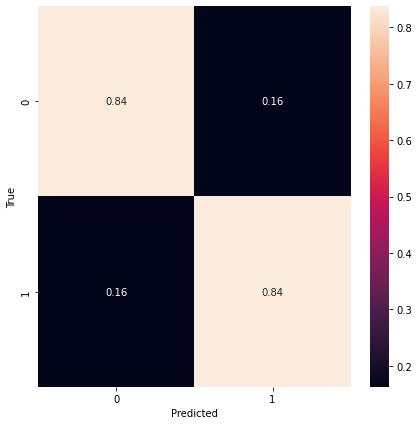

* Epoch 86 / 95


100%|██████████| 372/372 [02:14<00:00,  2.76it/s]


TRAIN - Time: 134.7s - Loss: 0.45265740244298863


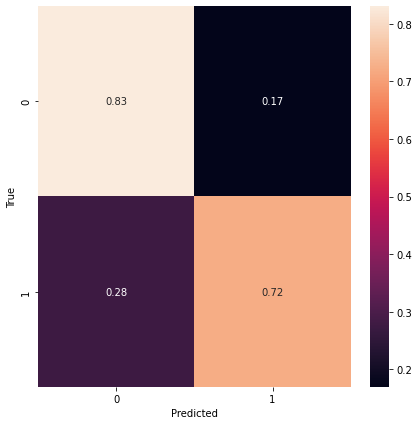

100%|██████████| 80/80 [00:15<00:00,  5.19it/s]


VALIDATION - Time: 15.4s - Loss: 0.4044486062601208


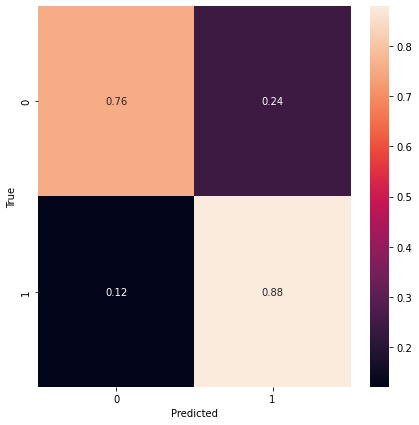

* Epoch 87 / 95


100%|██████████| 372/372 [02:13<00:00,  2.78it/s]


TRAIN - Time: 133.8s - Loss: 0.46379991096033885


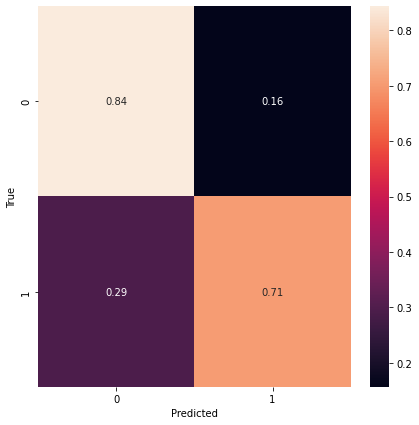

100%|██████████| 80/80 [00:15<00:00,  5.08it/s]


VALIDATION - Time: 15.8s - Loss: 0.39018228873610494


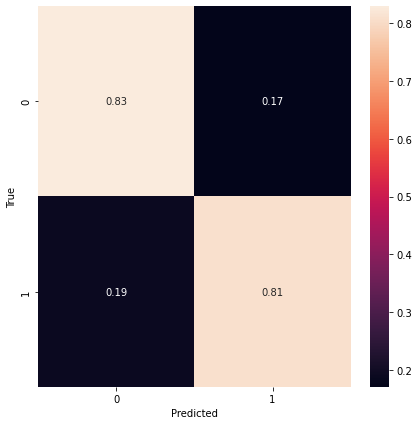

* Epoch 88 / 95


100%|██████████| 372/372 [02:15<00:00,  2.75it/s]


TRAIN - Time: 135.3s - Loss: 0.45372928739074747


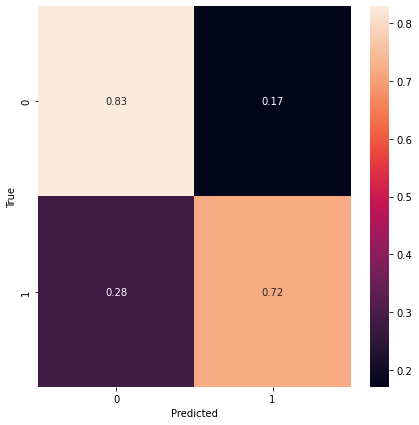

100%|██████████| 80/80 [00:17<00:00,  4.66it/s]


VALIDATION - Time: 17.2s - Loss: 0.3799481565132737


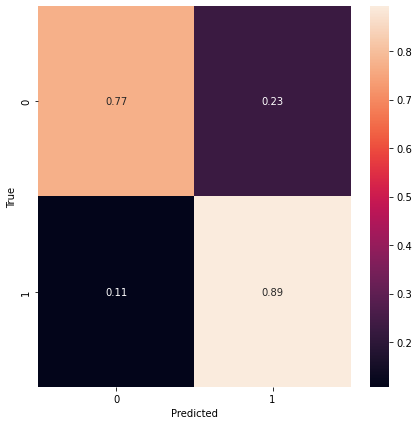

* Epoch 89 / 95


100%|██████████| 372/372 [02:15<00:00,  2.75it/s]


TRAIN - Time: 135.4s - Loss: 0.45143020349324386


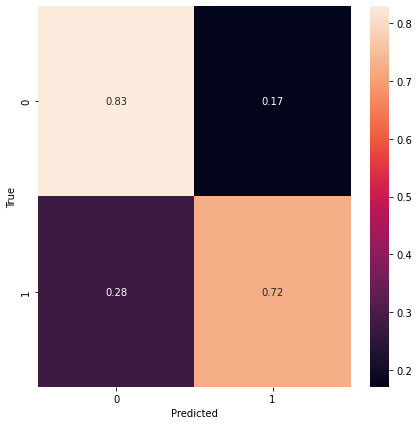

100%|██████████| 80/80 [00:15<00:00,  5.06it/s]


VALIDATION - Time: 15.8s - Loss: 0.3707797830924392


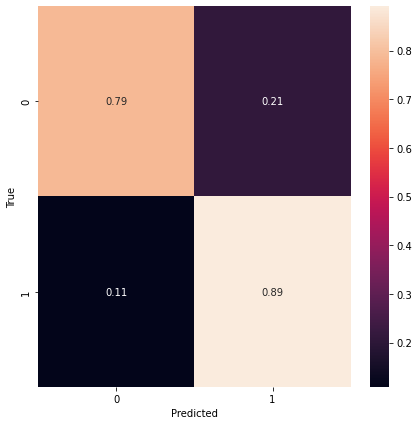

* Epoch 90 / 95


100%|██████████| 372/372 [02:14<00:00,  2.76it/s]


TRAIN - Time: 134.7s - Loss: 0.4582409464944436


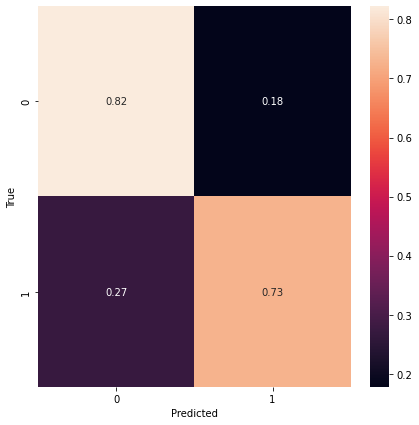

100%|██████████| 80/80 [00:15<00:00,  5.07it/s]


VALIDATION - Time: 15.8s - Loss: 0.3869636116549374


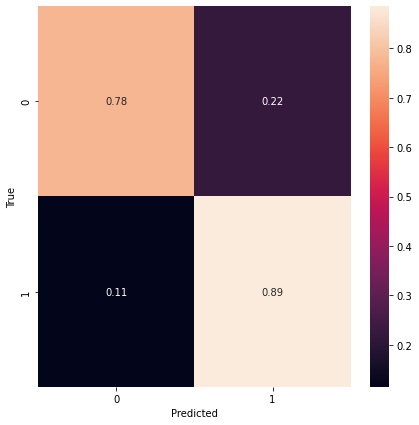

* Epoch 91 / 95


100%|██████████| 372/372 [02:15<00:00,  2.74it/s]


TRAIN - Time: 135.9s - Loss: 0.4507222979940391


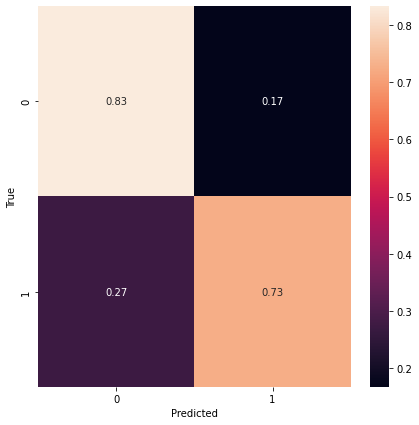

100%|██████████| 80/80 [00:15<00:00,  5.04it/s]


VALIDATION - Time: 15.9s - Loss: 0.3888797916471959


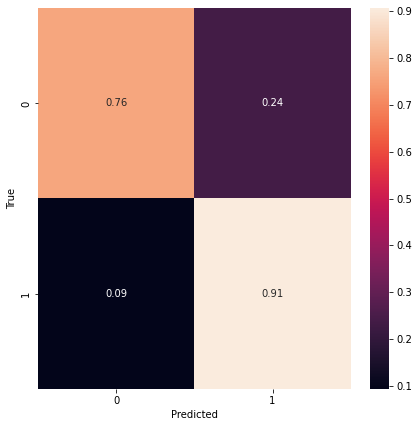

* Epoch 92 / 95


100%|██████████| 372/372 [02:11<00:00,  2.83it/s]


TRAIN - Time: 131.4s - Loss: 0.44195761559631225


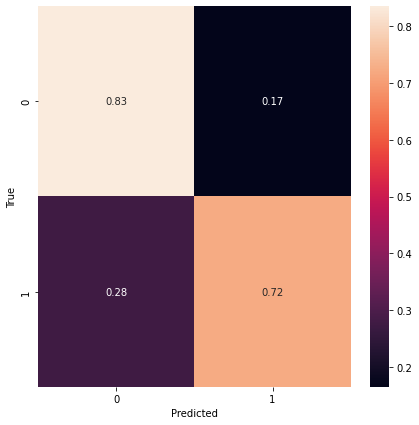

100%|██████████| 80/80 [00:14<00:00,  5.42it/s]


VALIDATION - Time: 14.8s - Loss: 0.3814792467281221


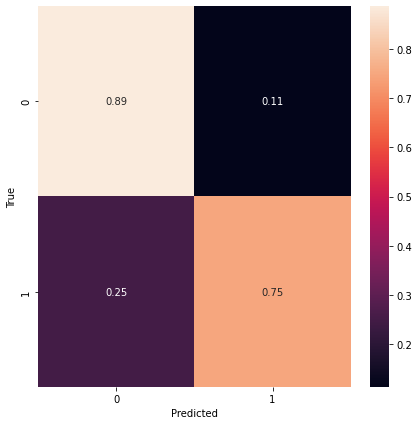

* Epoch 93 / 95


100%|██████████| 372/372 [02:14<00:00,  2.76it/s]


TRAIN - Time: 134.6s - Loss: 0.45915384935114995


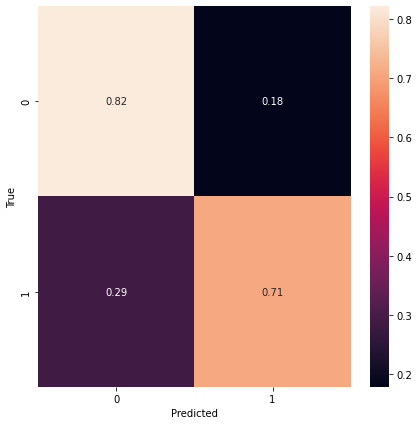

100%|██████████| 80/80 [00:14<00:00,  5.35it/s]


VALIDATION - Time: 15.0s - Loss: 0.4235812118276954


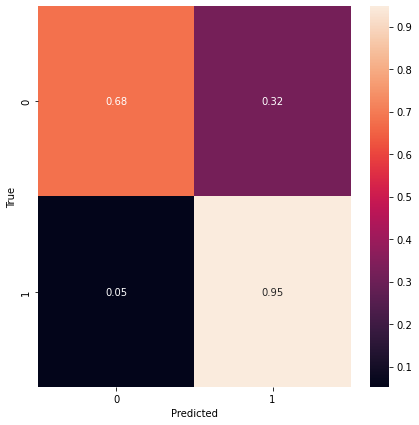

* Epoch 94 / 95


100%|██████████| 372/372 [02:15<00:00,  2.75it/s]


TRAIN - Time: 135.2s - Loss: 0.45404007758504583


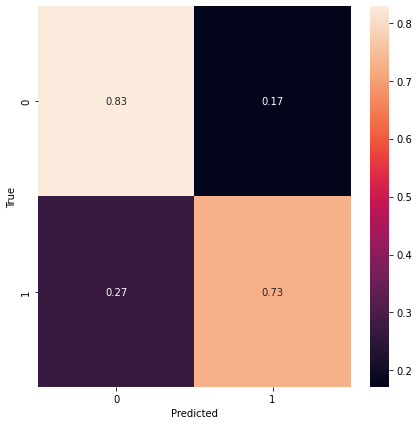

100%|██████████| 80/80 [00:15<00:00,  5.20it/s]


VALIDATION - Time: 15.4s - Loss: 0.3894392156973481


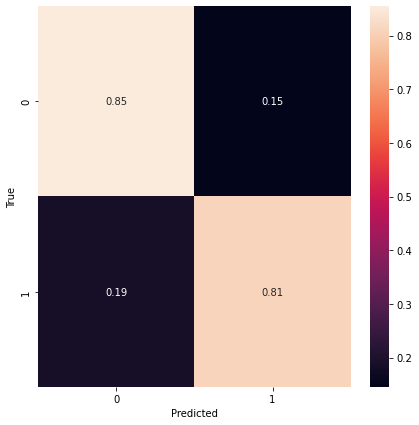

* Epoch 95 / 95


100%|██████████| 372/372 [02:16<00:00,  2.73it/s]


TRAIN - Time: 136.1s - Loss: 0.44863370481518045


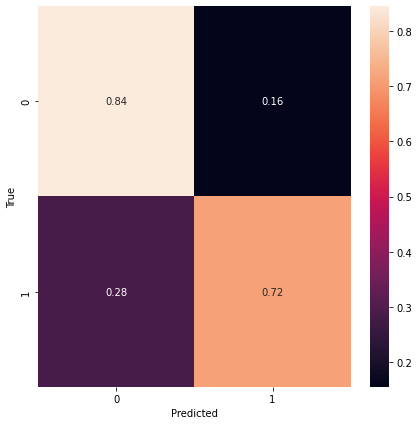

100%|██████████| 80/80 [00:15<00:00,  5.29it/s]


VALIDATION - Time: 15.1s - Loss: 0.3825172808021306


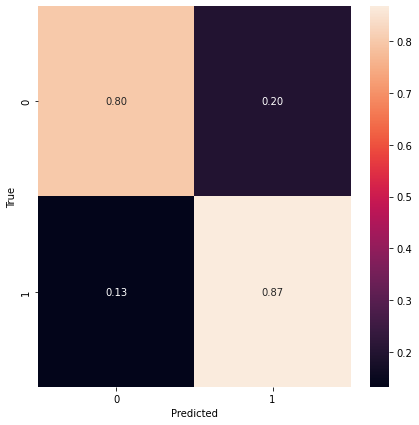

In [ ]:
################## DATA LOADING AND MODEL ##################

# Data albumentations
aug_1 = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(0.1),
    A.Rotate(180),
]

aug_2 = [
    A.Resize(img_size + img_size//20, img_size + img_size//20),
    A.RandomCrop(img_size, img_size),
    ToTensorV2()
]

train_transforms = A.Compose(aug_1 + aug_2)
transforms = A.Compose(aug_2)

# Data Splitting

print ("Loading dataset\n")
 
detection_dataset = pd.read_csv('/content/drive/Shareddrives/Projeto DACO/single label dataset/dataset_labels.csv')

label_encoder_1 = preprocessing.LabelEncoder()
detection_dataset ['presence'] = label_encoder_1.fit_transform(detection_dataset ['presence'])

# Labels map
print("Detection's Label Map")
print("Class 0 - ", label_encoder_1.inverse_transform([0]))
print("Class 1 - ", label_encoder_1.inverse_transform([1]))

d_train_set, d_val_set = train_test_split(detection_dataset, test_size=0.3, random_state=123) # 70% training data (30% validation+test data)
d_val_set, d_test_set = train_test_split(d_val_set, test_size=0.5, random_state=123) # 15% validation data, 15% test data

d_train_set, d_val_set = d_train_set.reset_index(drop=True), d_val_set.reset_index(drop=True)

d_train_set = small_dataset(d_train_set, dataset_fold, train_transforms)
d_val_set = small_dataset(d_val_set, dataset_fold, transforms)

tr = DataLoader(d_train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val = DataLoader(d_val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print ("\nLoaded \n")

# Model

if (model_selected == 'VGG'):
  model = VGG16()
elif (model_selected == 'ResNeXt'):
  ResNeXt = models.resnext101_32x8d(pretrained=False, num_classes=6)
  model = ResNeXt()

opt = optim.Adam(model.parameters(), lr = LEARNING_RATE)

class_weights = class_weight.compute_class_weight(
              class_weight='balanced',
              classes=[0, 1], 
              y=detection_dataset['presence'])

class_weights = torch.tensor(class_weights,dtype=torch.float).cuda()

loss_fc = nn.CrossEntropyLoss(weight=class_weights)

################## TRAINING ##################

print("\nTraining")

train_history = []
val_history = []
best_val_loss = np.inf

epoch_values = []

for epoch in range(EPOCHS):
      print(f'* Epoch {epoch+1} / {EPOCHS}')
      
      train_loss, tr_true_pred, tr_final_pred = epoch_iterations (tr, model, loss_fc, device, 'TRAIN', opt, True)
      evaluation_metrics(tr_true_pred, tr_final_pred)
      
      val_loss, val_true_pred, val_final_pred = epoch_iterations (val, model, loss_fc, device, 'VALIDATION', None,  False)
      evaluation_metrics(val_true_pred, val_final_pred)

      if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_selected + '_detection_best_model.pth')

      # save latest model
      torch.save(model.state_dict(), model_selected + '_detection_latest_model.pth')

      # save training history for plotting purposes
      train_history.append(train_loss)
      val_history.append(val_loss)
      epoch_values.append(epoch+1)
  

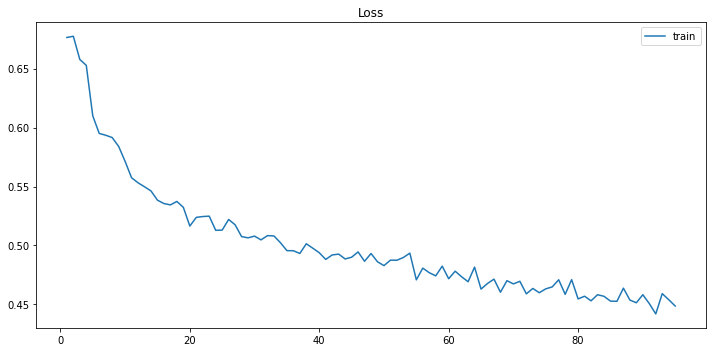

In [ ]:
loss_plot2 (epoch_values, train_history)

In [ ]:
# Saves values in a csv file

info= pd.DataFrame({"epoch": epoch_values, "training loss": train_history, "validation loss": val_history})
info.to_csv('/content/drive/Shareddrives/Projeto DACO/loss_detection_95epochs.csv', index=False, header=True)